In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from utility import *

### Data loading

In [3]:
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = to_categorical(np.ravel(y_train))
y_test = to_categorical(np.ravel(y_test))

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

label_names = {
    0: 'plane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)


# Neural Network

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=False,
    featurewise_center=True,
    featurewise_std_normalization=True,
    #zca_whitening=True,
    fill_mode='reflect',
    validation_split=0.02
)

train_datagen.fit(x_train)

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers.maxout import Maxout

def maxout_nn_model(show_summary=False):
    inputs = tf.keras.layers.Input((32, 32, 3))
    
    hidden = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    hidden = Maxout(num_units=64)(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)    
        
    hidden = tf.keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same')(hidden)
    hidden = Maxout(num_units=96)(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    
    hidden = tf.keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same')(hidden)
    hidden = Maxout(num_units=192)(hidden)
    hidden = tf.keras.layers.MaxPool2D((2,2))(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    #hidden = tf.keras.layers.Dropout(0.1)(hidden)
    
    hidden = tf.keras.layers.Conv2D(768, (3, 3), activation='relu', padding='same')(hidden)
    hidden = Maxout(num_units=384)(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(0.2)(hidden)
    
    hidden = tf.keras.layers.GlobalAveragePooling2D()(hidden)
    
    hidden = tf.keras.layers.Dense(384, activation='relu', activity_regularizer=tf.keras.regularizers.L2())(hidden)
    hidden = Maxout(num_units=192)(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(0.25)(hidden)
    
    outputs = tf.keras.layers.Dense(10, activation='softmax')(hidden)
    
    model = tf.keras.Model(inputs, outputs)
    metrics = [
        tfa.metrics.F1Score(num_classes=10, average="weighted"),
        'accuracy'
    ]
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    if show_summary:
        print(model.summary())
    
    return model

In [6]:
model = maxout_nn_model(show_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
maxout (Maxout)              (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 192)       110784    
_________________________________________________________________
maxout_1 (Maxout)            (None, 16, 16, 96)        0     

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

save_best = ModelCheckpoint('models/best_weights_final.hdf5', save_best_only=True, monitor='val_f1_score', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.2, patience=5, verbose=1, cooldown=2)

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=64, subset='training'),
    steps_per_epoch=765,
    validation_data=train_datagen.flow(x_train, y_train, batch_size=64, subset='validation'),
    validation_steps=16,
    callbacks=[save_best, reduce_lr],
    epochs=50
)

Epoch 1/50
765/765 [==============================] - 40s 50ms/step - loss: 1.8999 - f1_score: 0.4120 - accuracy: 0.4150 - val_loss: 1.4259 - val_f1_score: 0.5063 - val_accuracy: 0.5170
Epoch 2/50
765/765 [==============================] - 39s 51ms/step - loss: 1.2974 - f1_score: 0.5593 - accuracy: 0.5608 - val_loss: 1.1708 - val_f1_score: 0.5921 - val_accuracy: 0.6000
Epoch 3/50
765/765 [==============================] - 38s 49ms/step - loss: 1.1431 - f1_score: 0.6213 - accuracy: 0.6223 - val_loss: 1.0700 - val_f1_score: 0.6411 - val_accuracy: 0.6510
Epoch 4/50
765/765 [==============================] - 38s 50ms/step - loss: 1.0367 - f1_score: 0.6618 - accuracy: 0.6625 - val_loss: 0.9746 - val_f1_score: 0.6800 - val_accuracy: 0.6810
Epoch 5/50
765/765 [==============================] - 38s 50ms/step - loss: 0.9567 - f1_score: 0.6868 - accuracy: 0.6874 - val_loss: 0.9269 - val_f1_score: 0.6886 - val_accuracy: 0.6930
Epoch 6/50
765/765 [==============================] - 39s 51ms/step - 

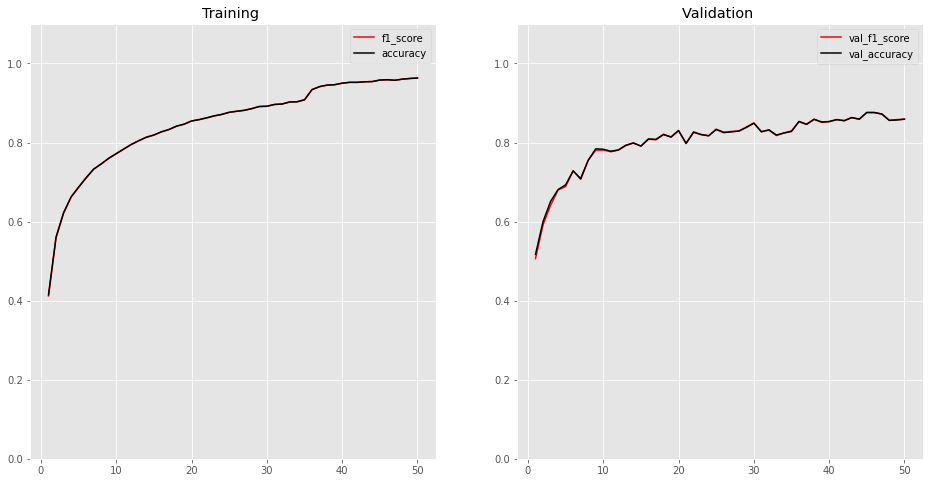

In [21]:
%matplotlib inline
plot_history(history.history)

In [7]:
model.load_weights('models/best_weights_final.hdf5')

test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.fit(x_train)

model.evaluate(test_datagen.flow(x_test, y_test))

313/313 [==============================] - 14s 43ms/step - loss: 0.4933 - f1_score: 0.8636 - accuracy: 0.8641


[0.49331915378570557, 0.8636244535446167, 0.8640999794006348]

# F1 = 0.86

This is an acceptable accuracy. Let's take a look at best matches and their convolutions, and call it a day.

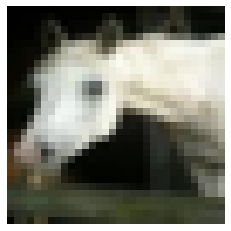

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


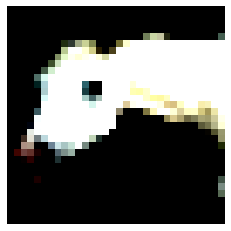

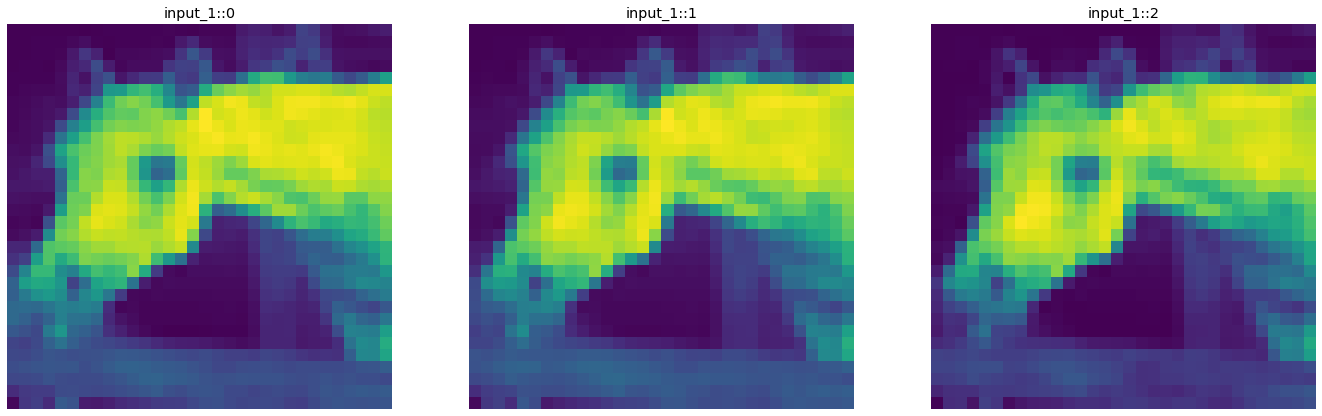

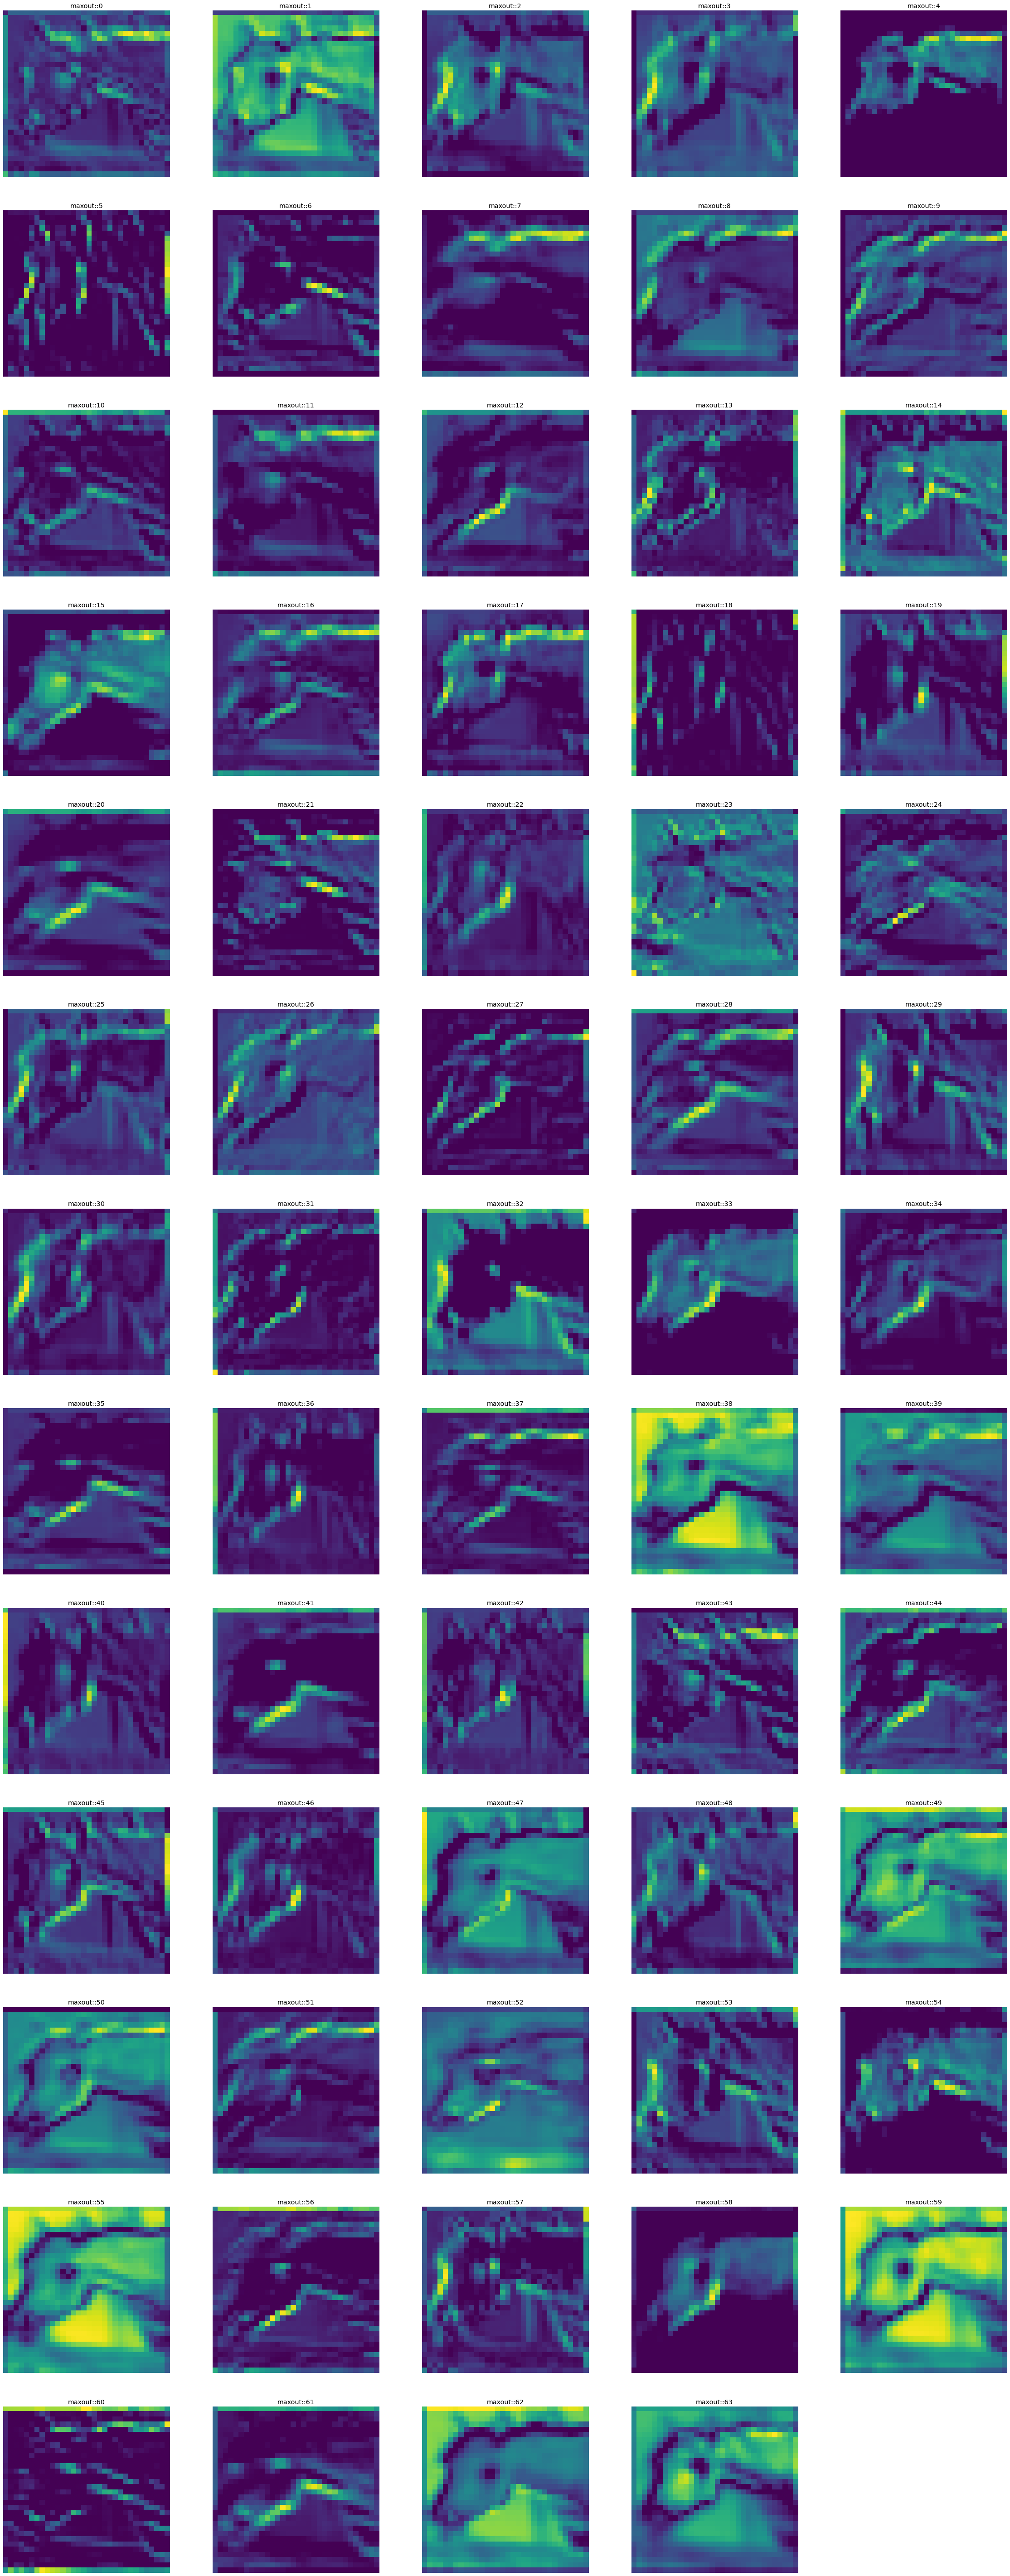

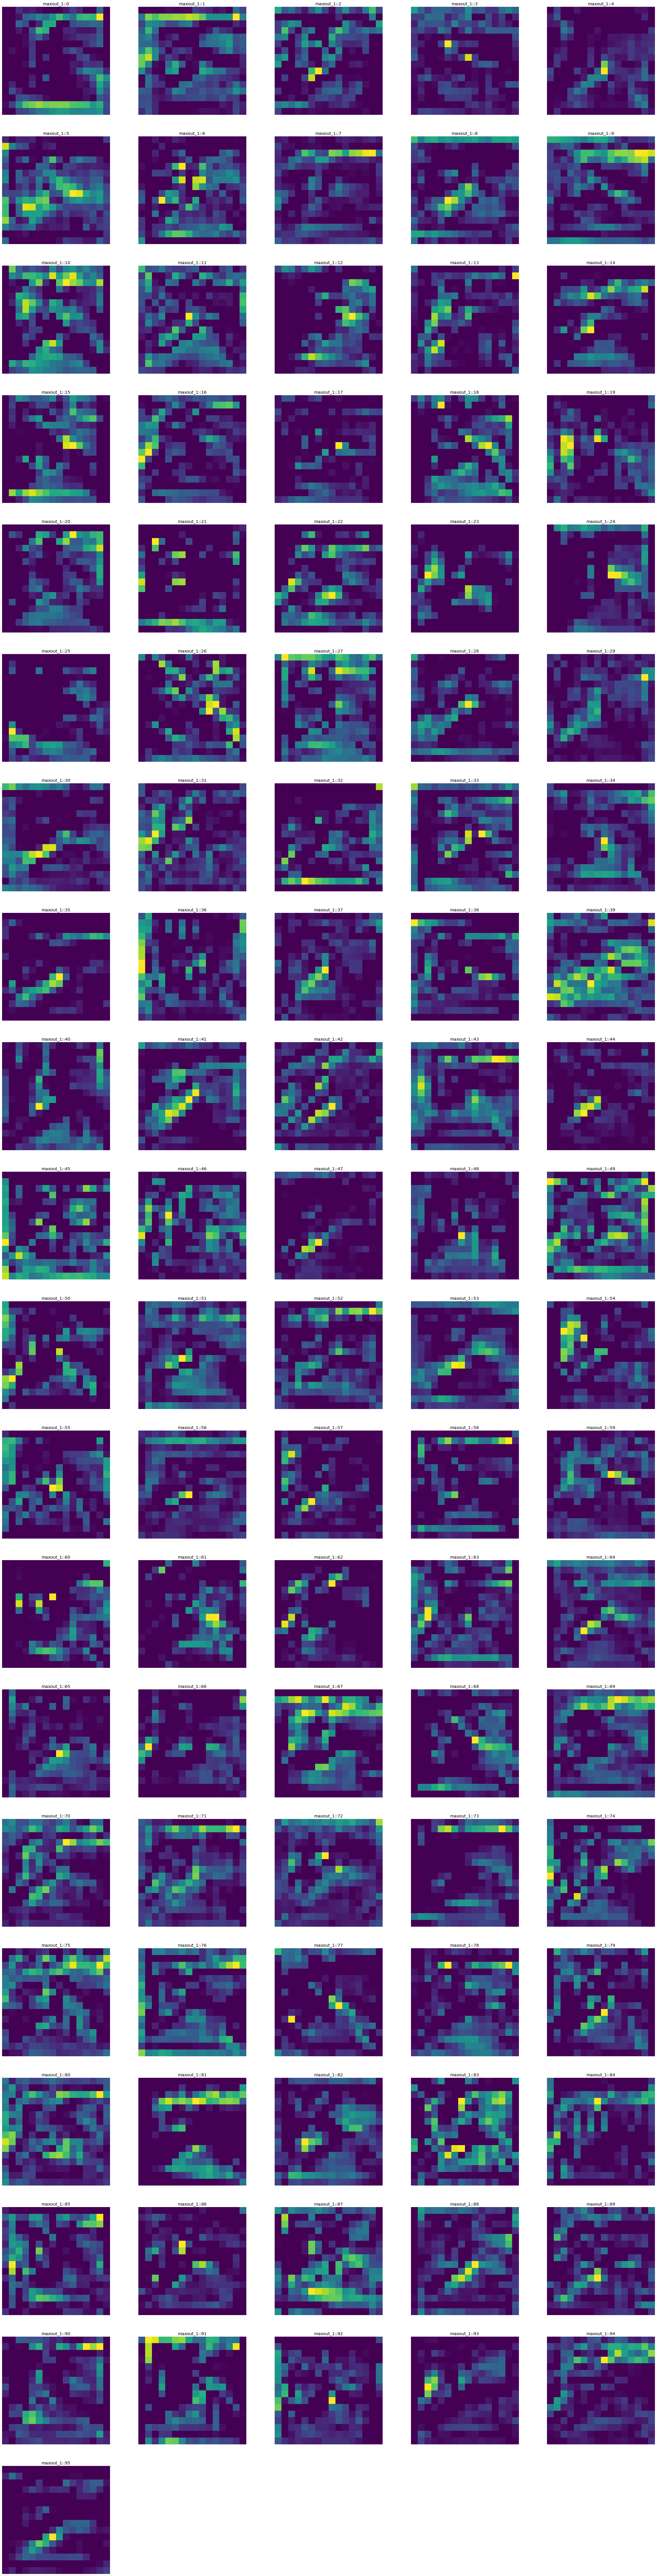

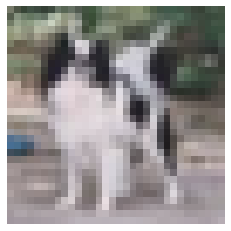

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


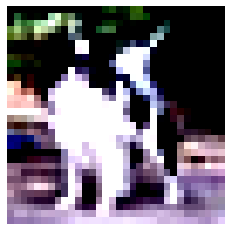

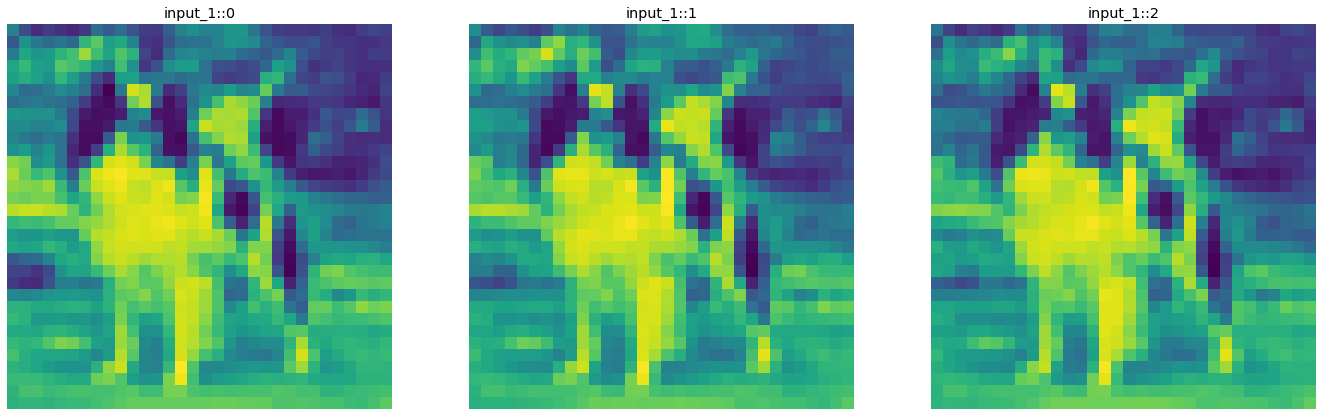

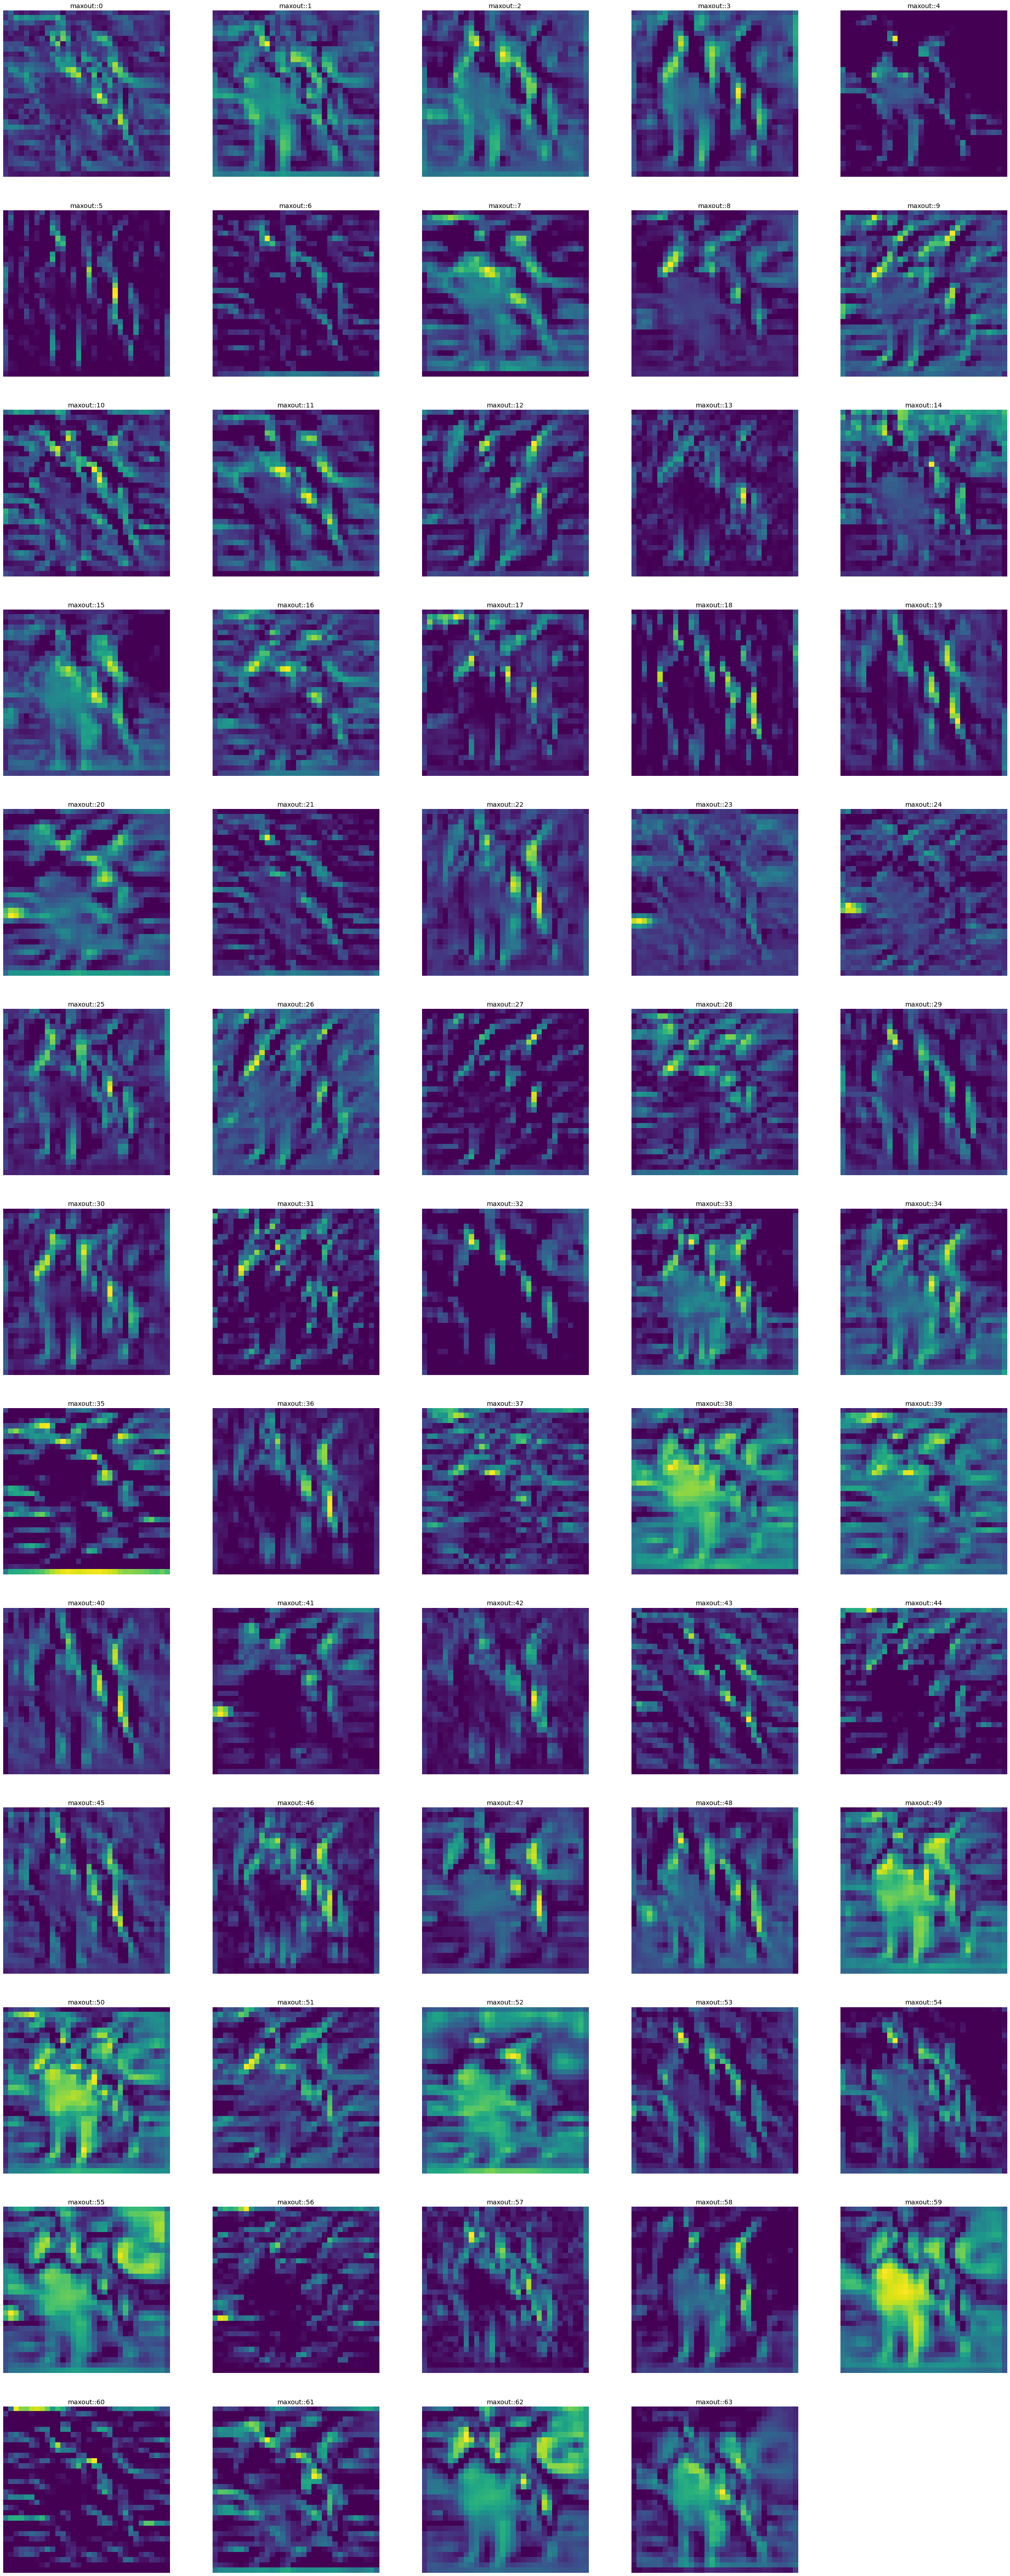

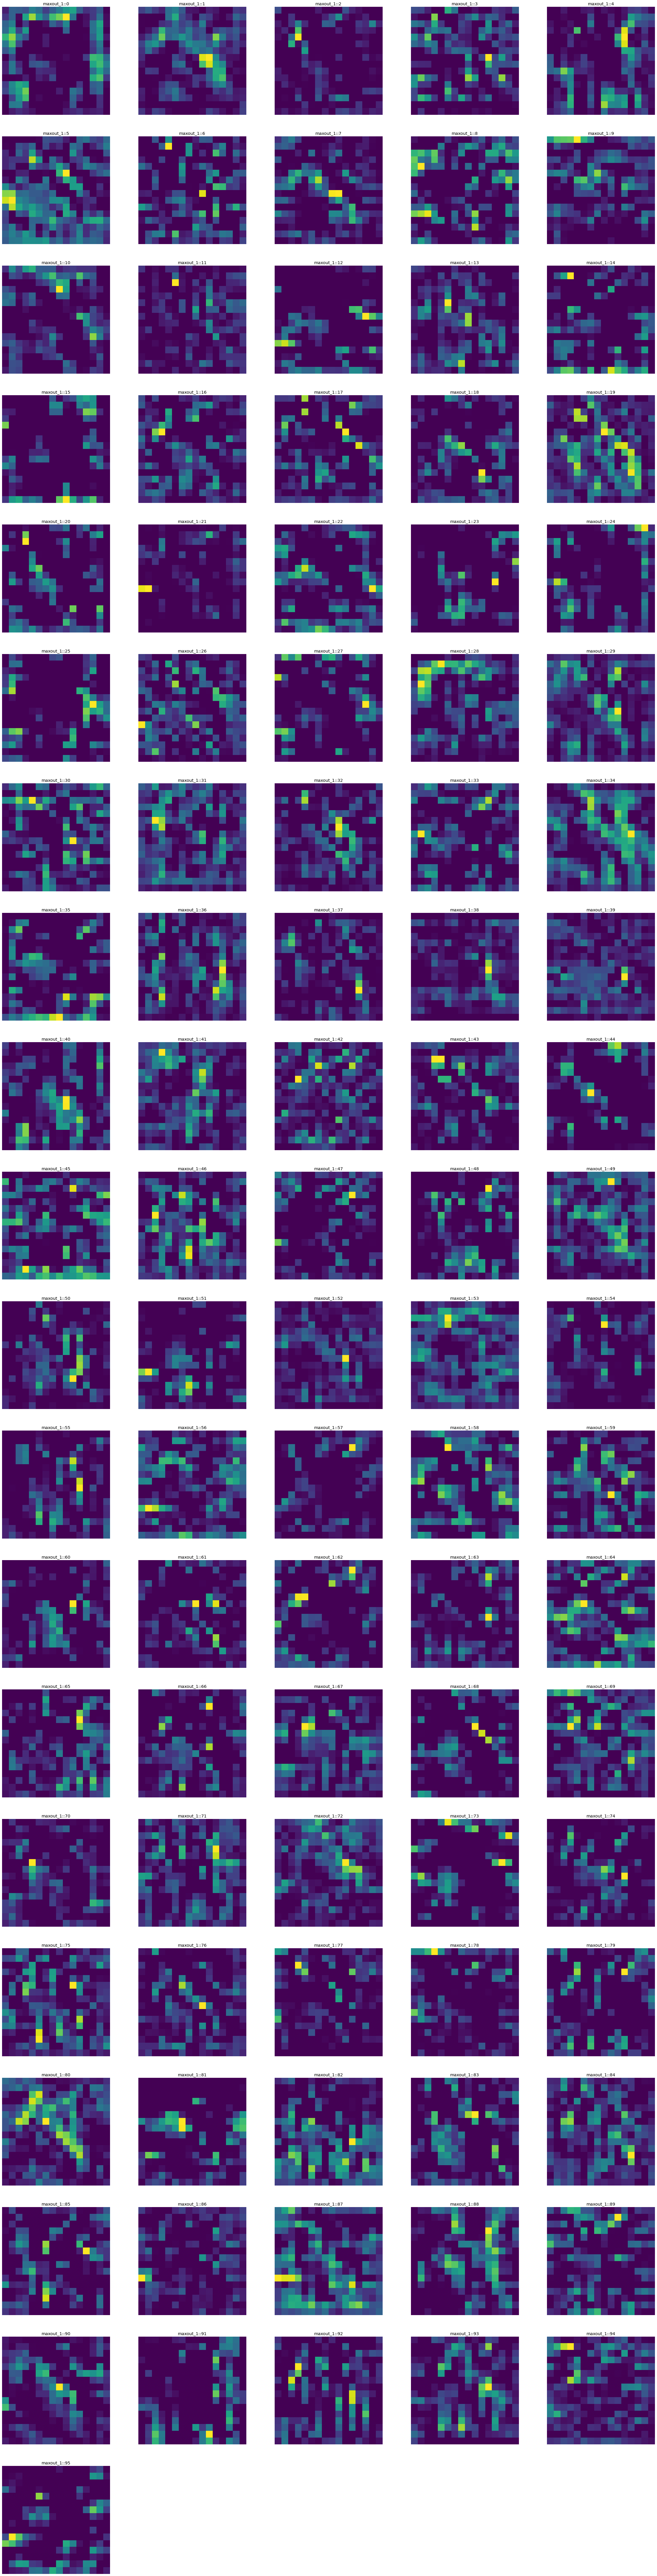

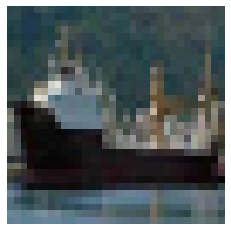

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


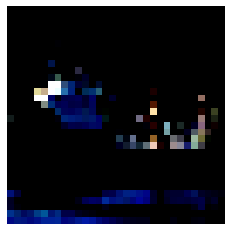

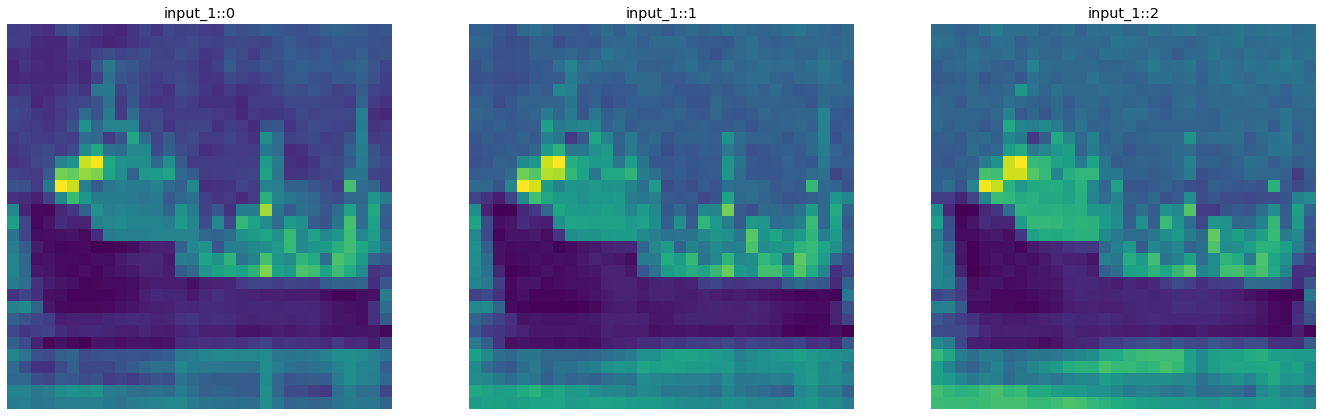

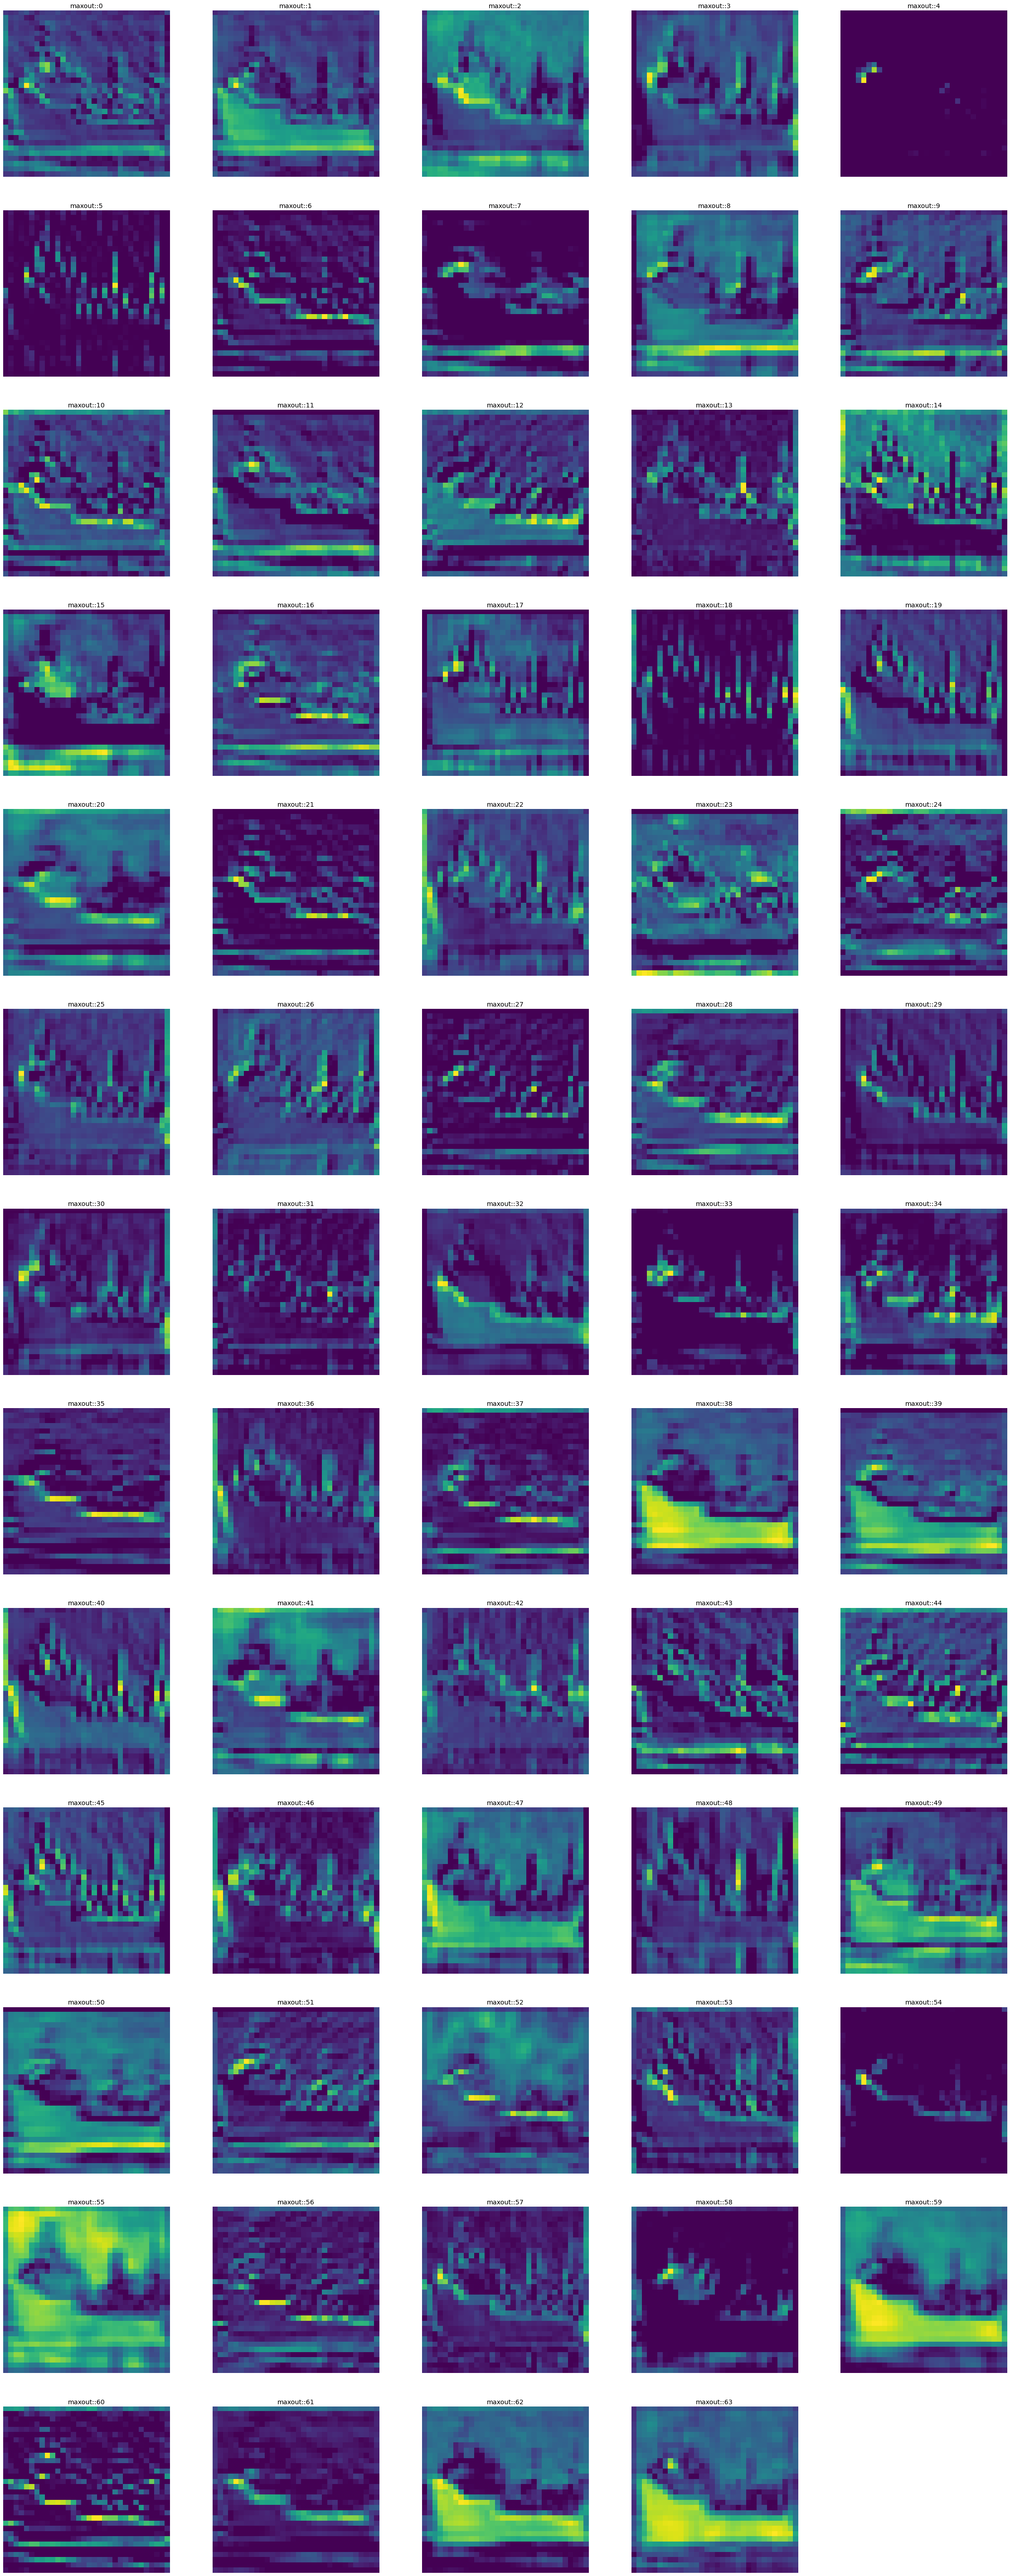

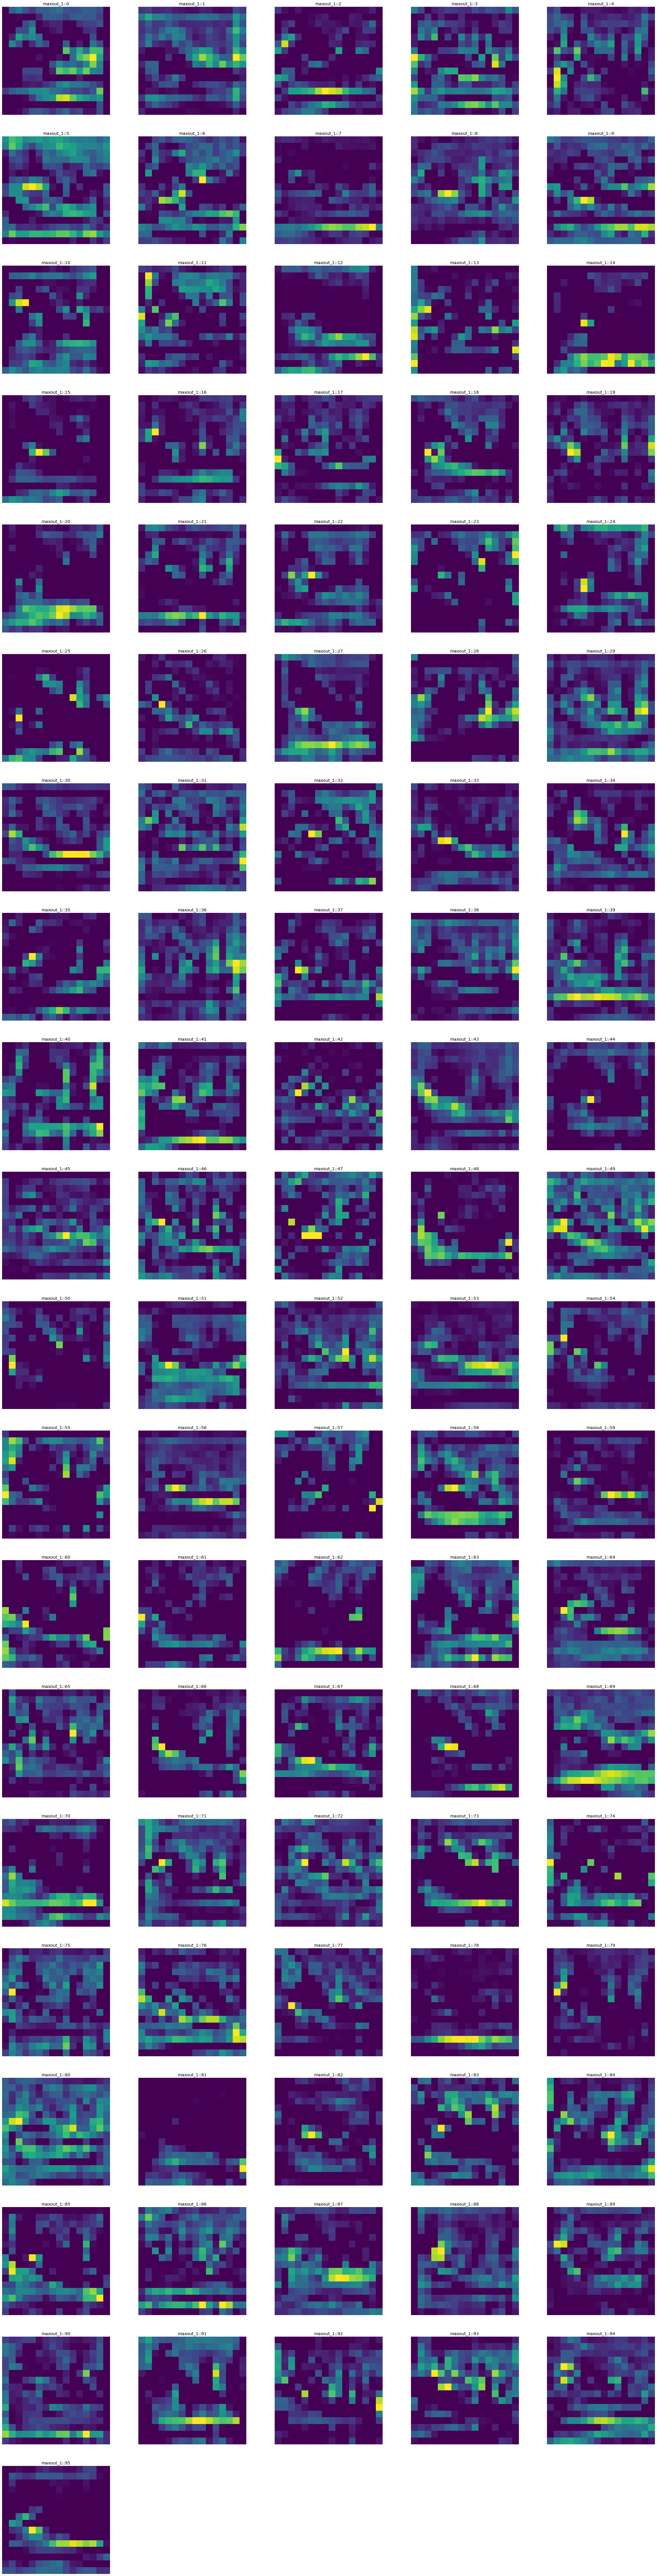

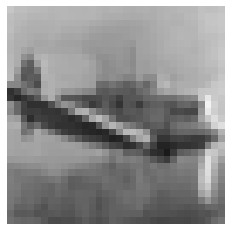

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


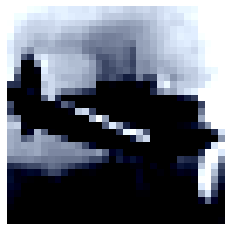

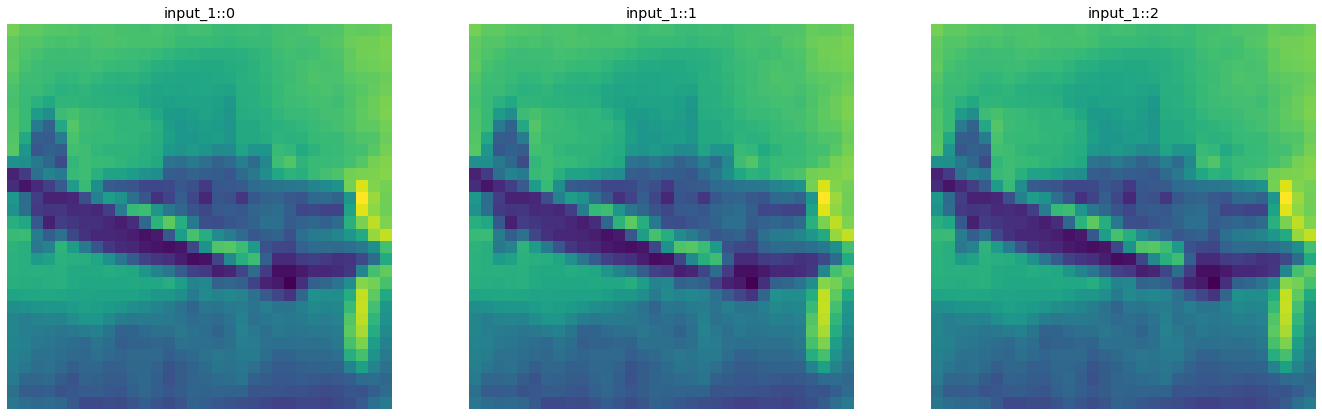

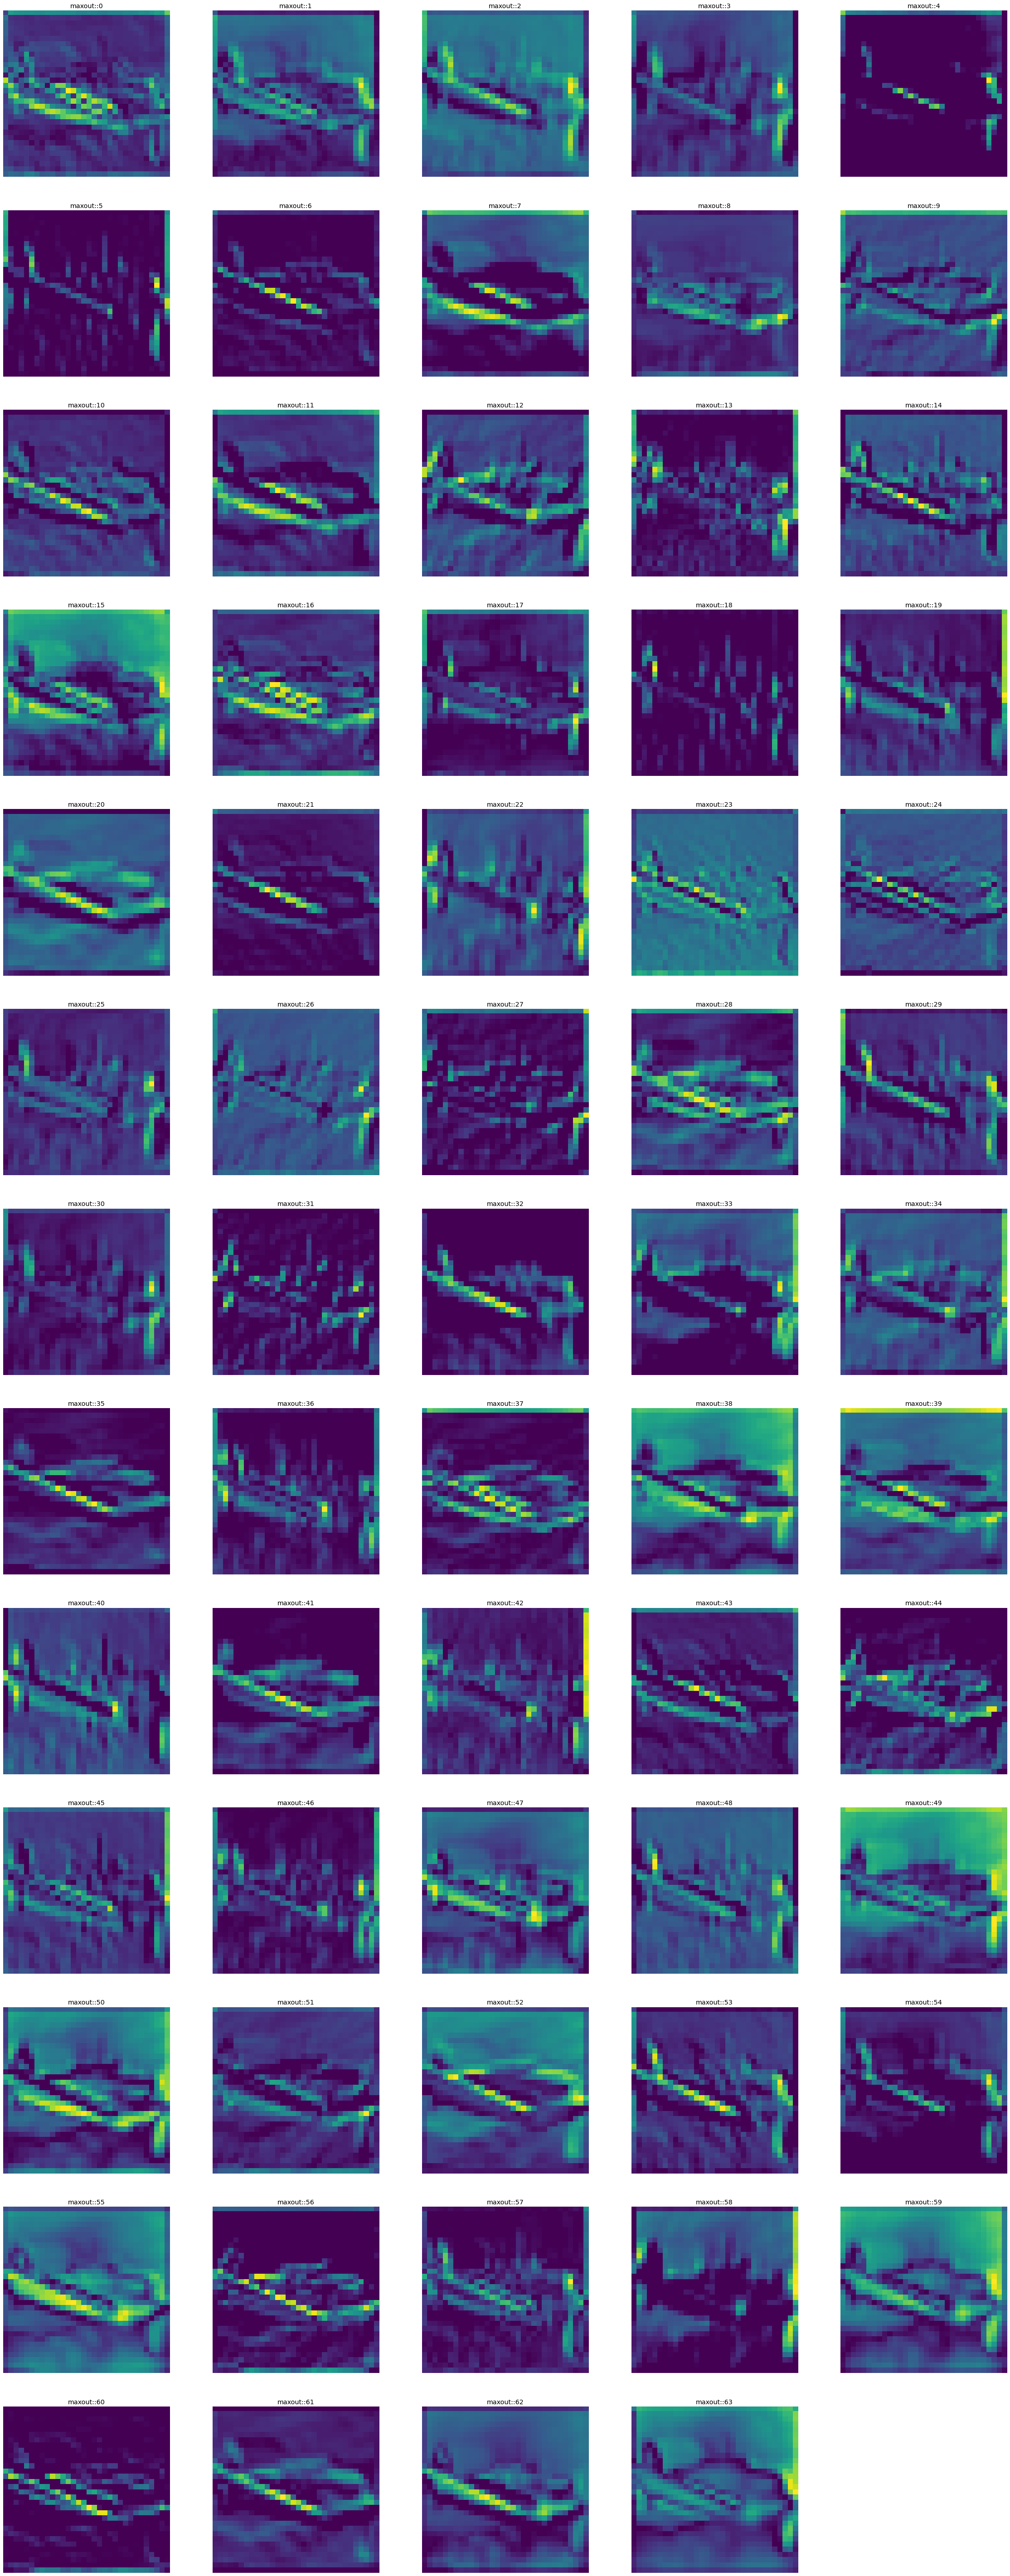

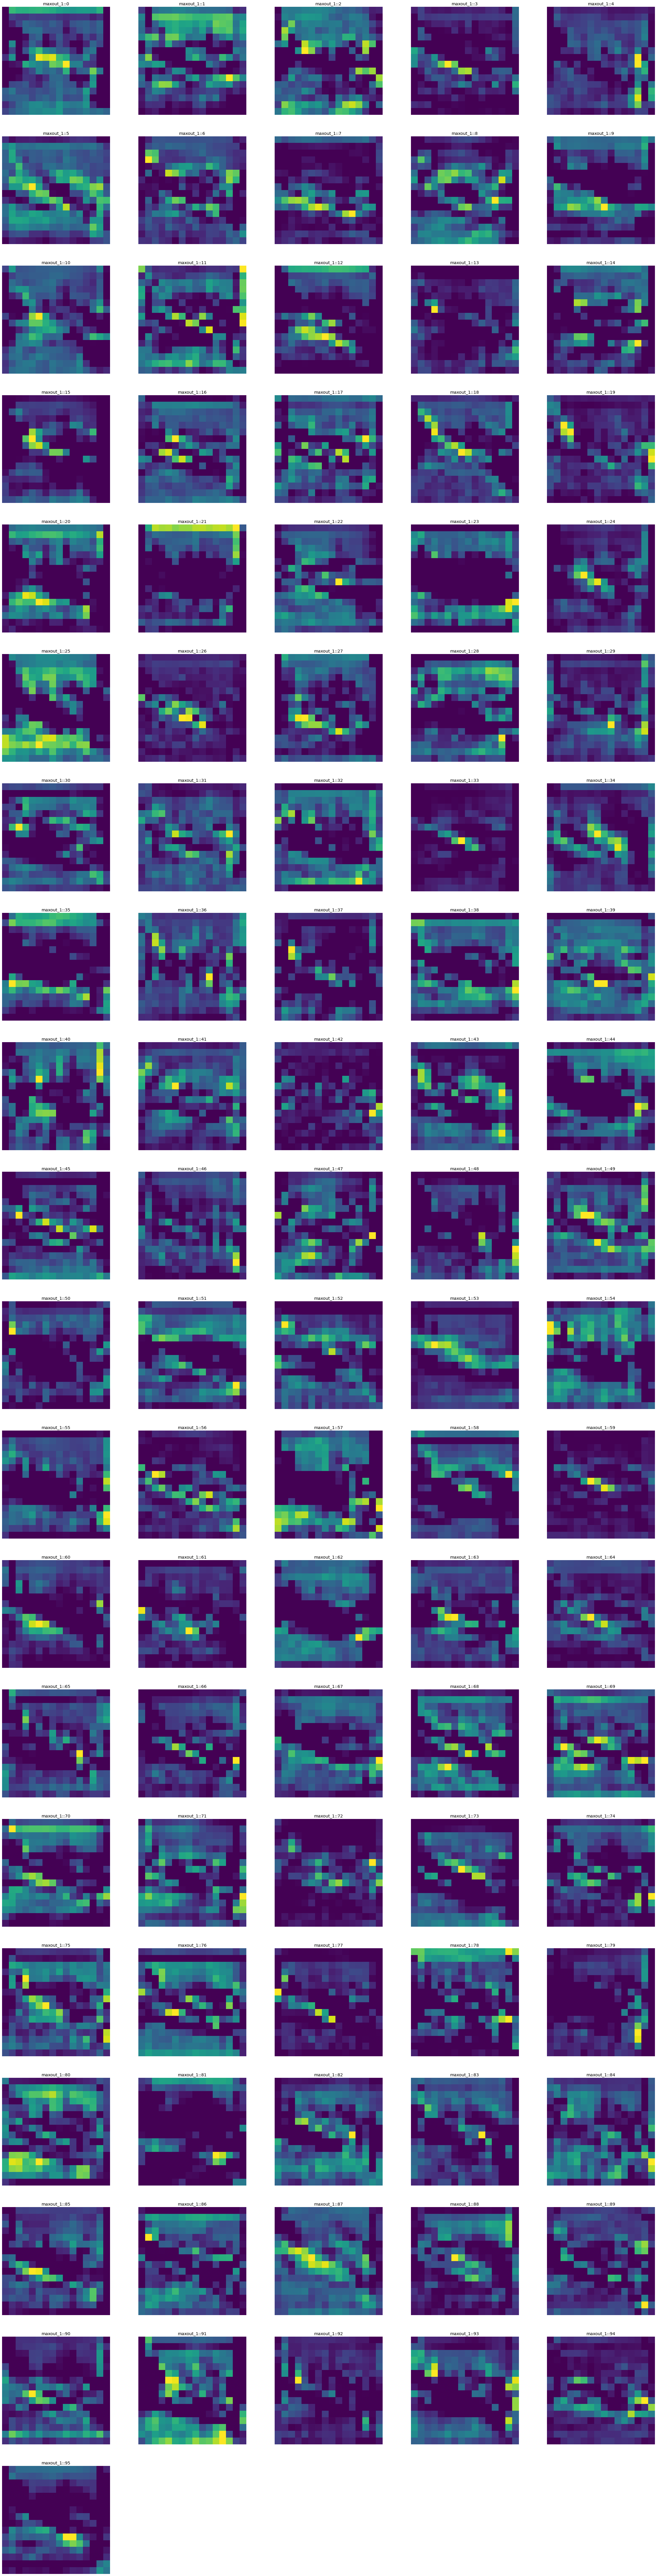

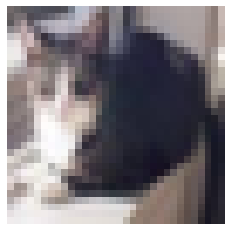

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


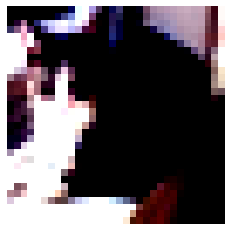

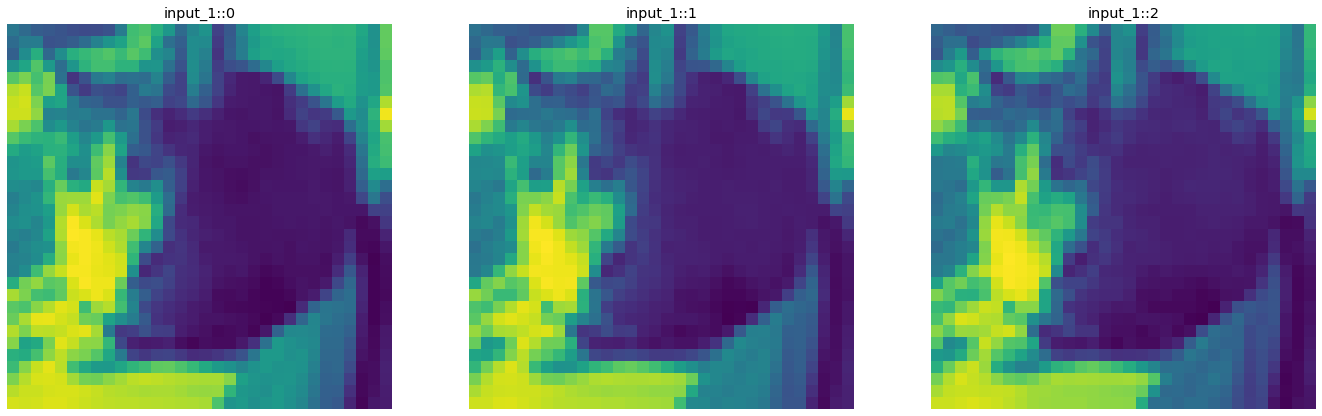

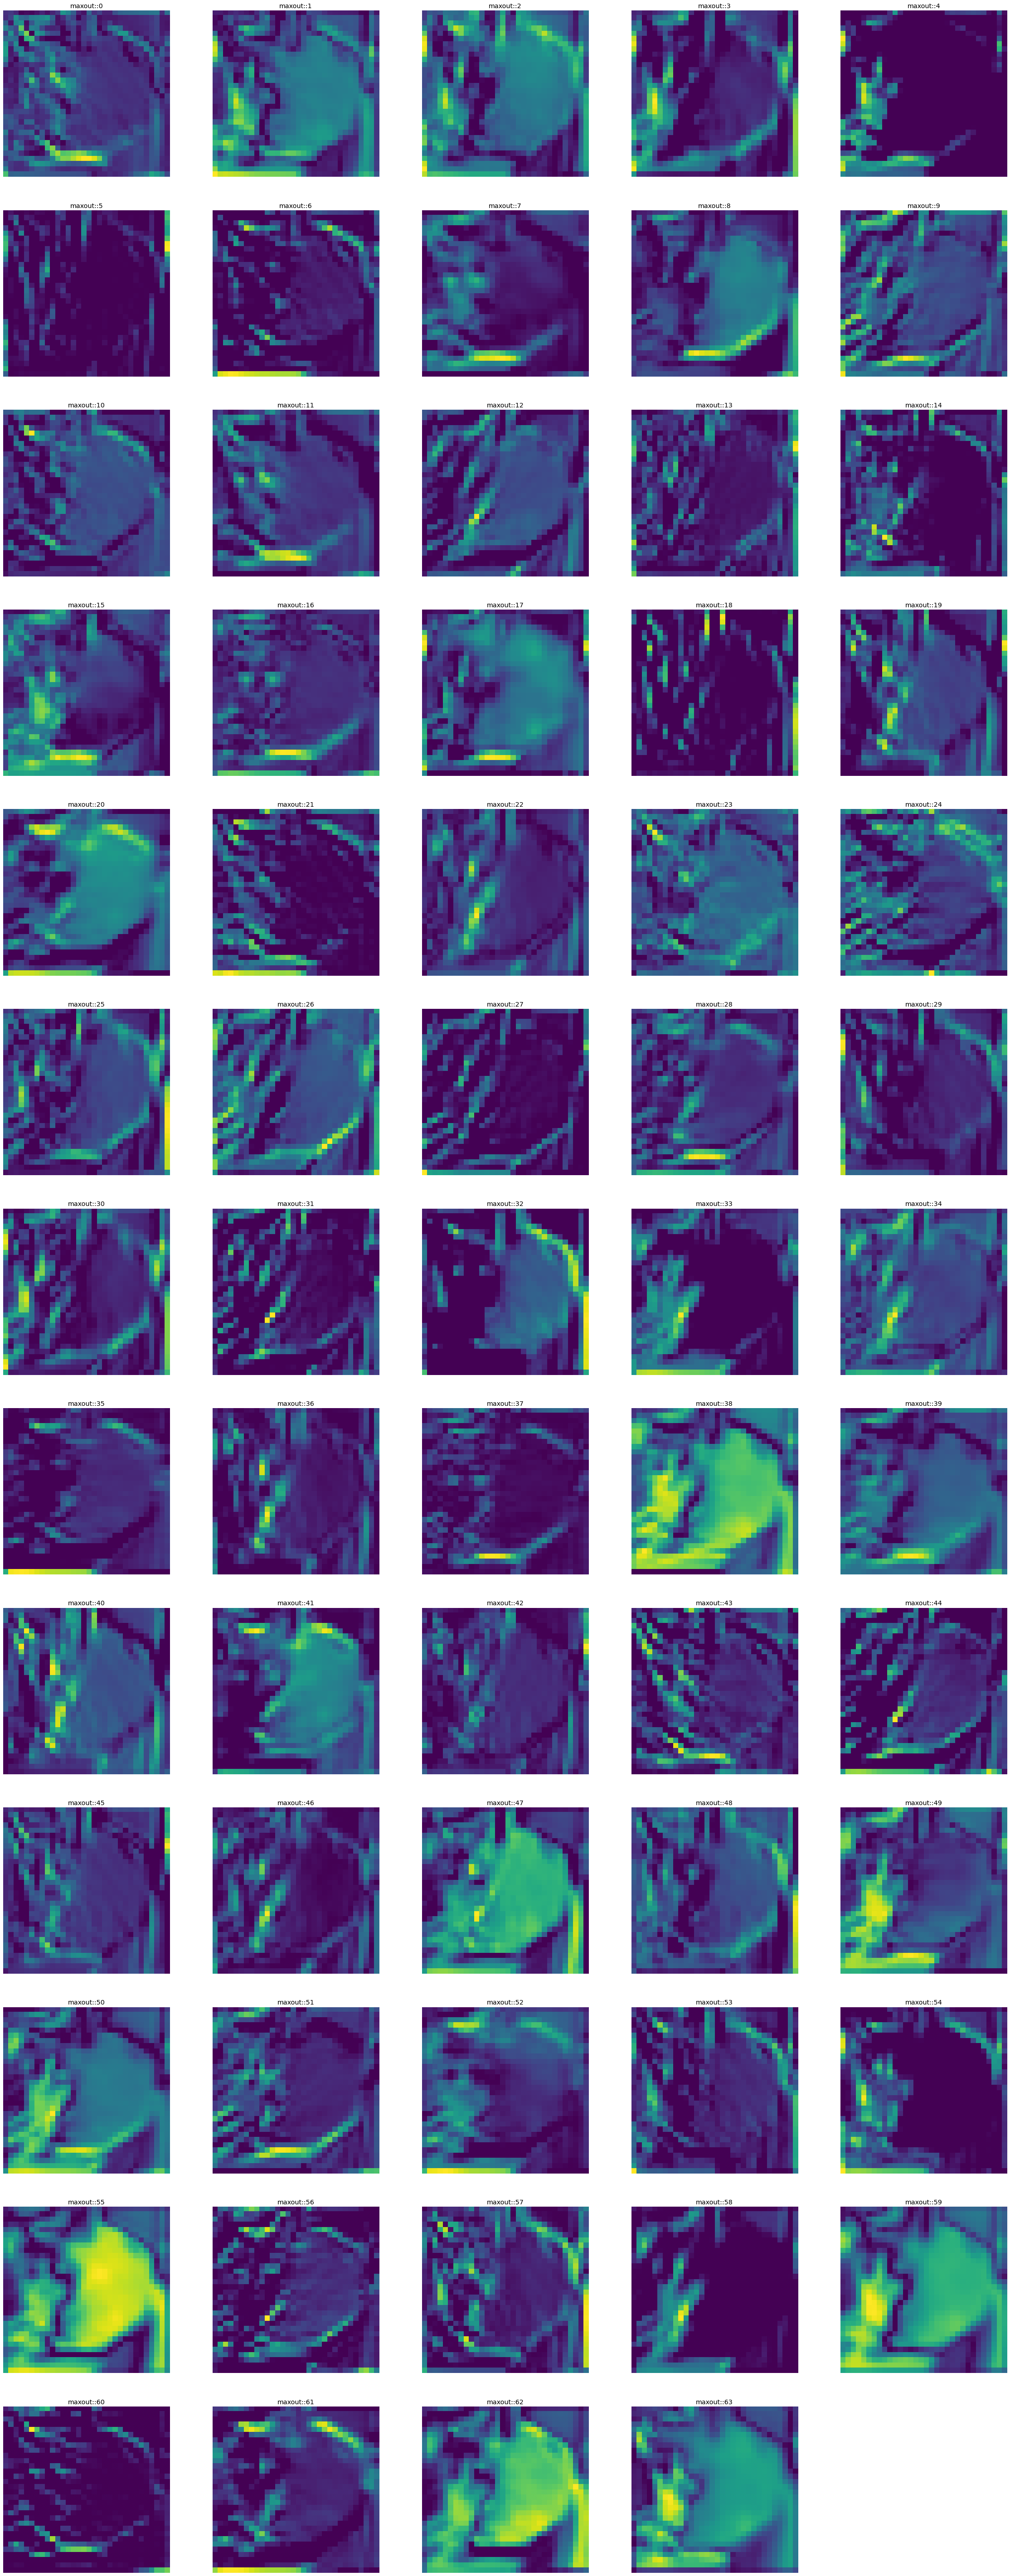

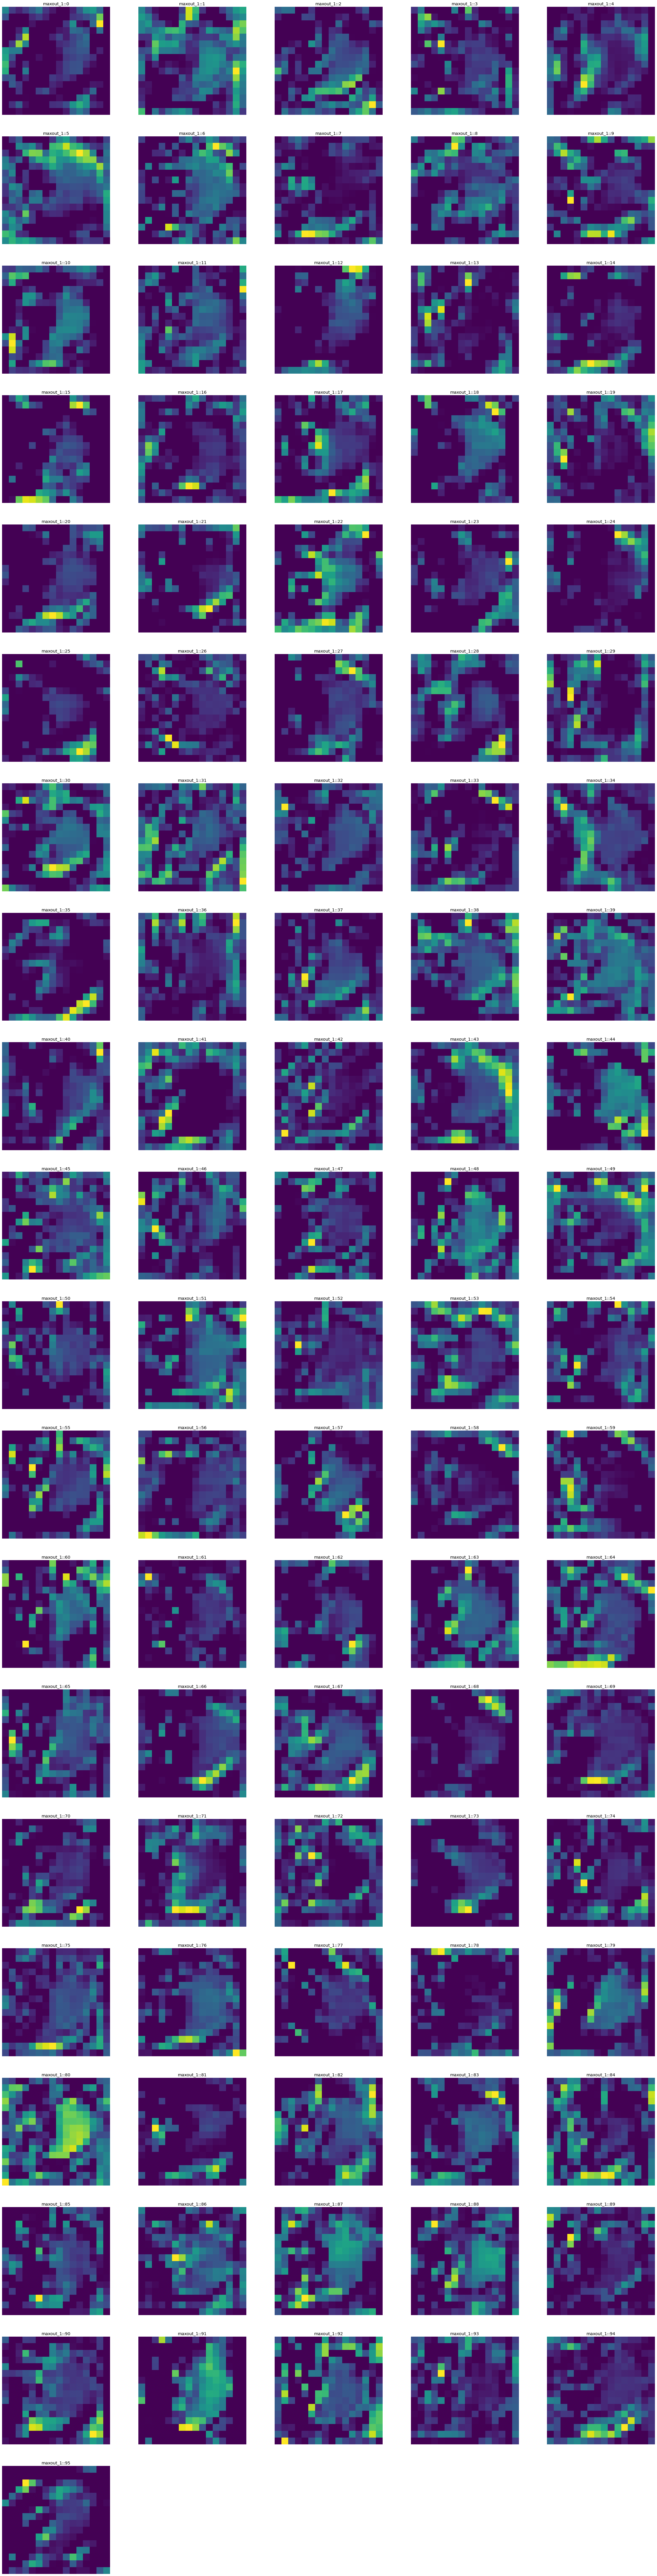

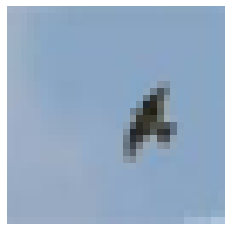

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


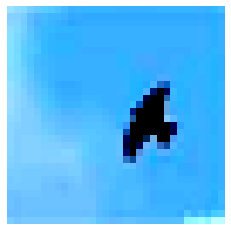

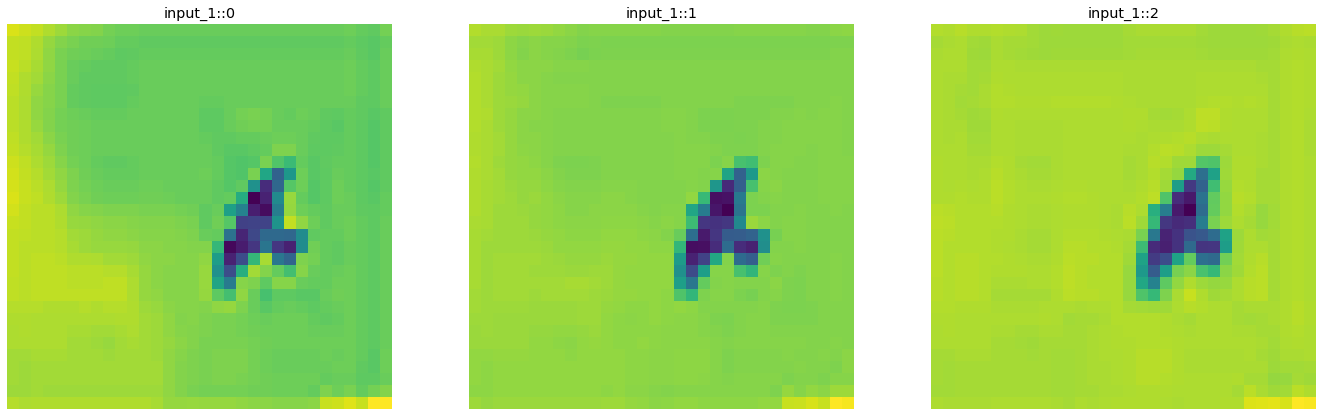

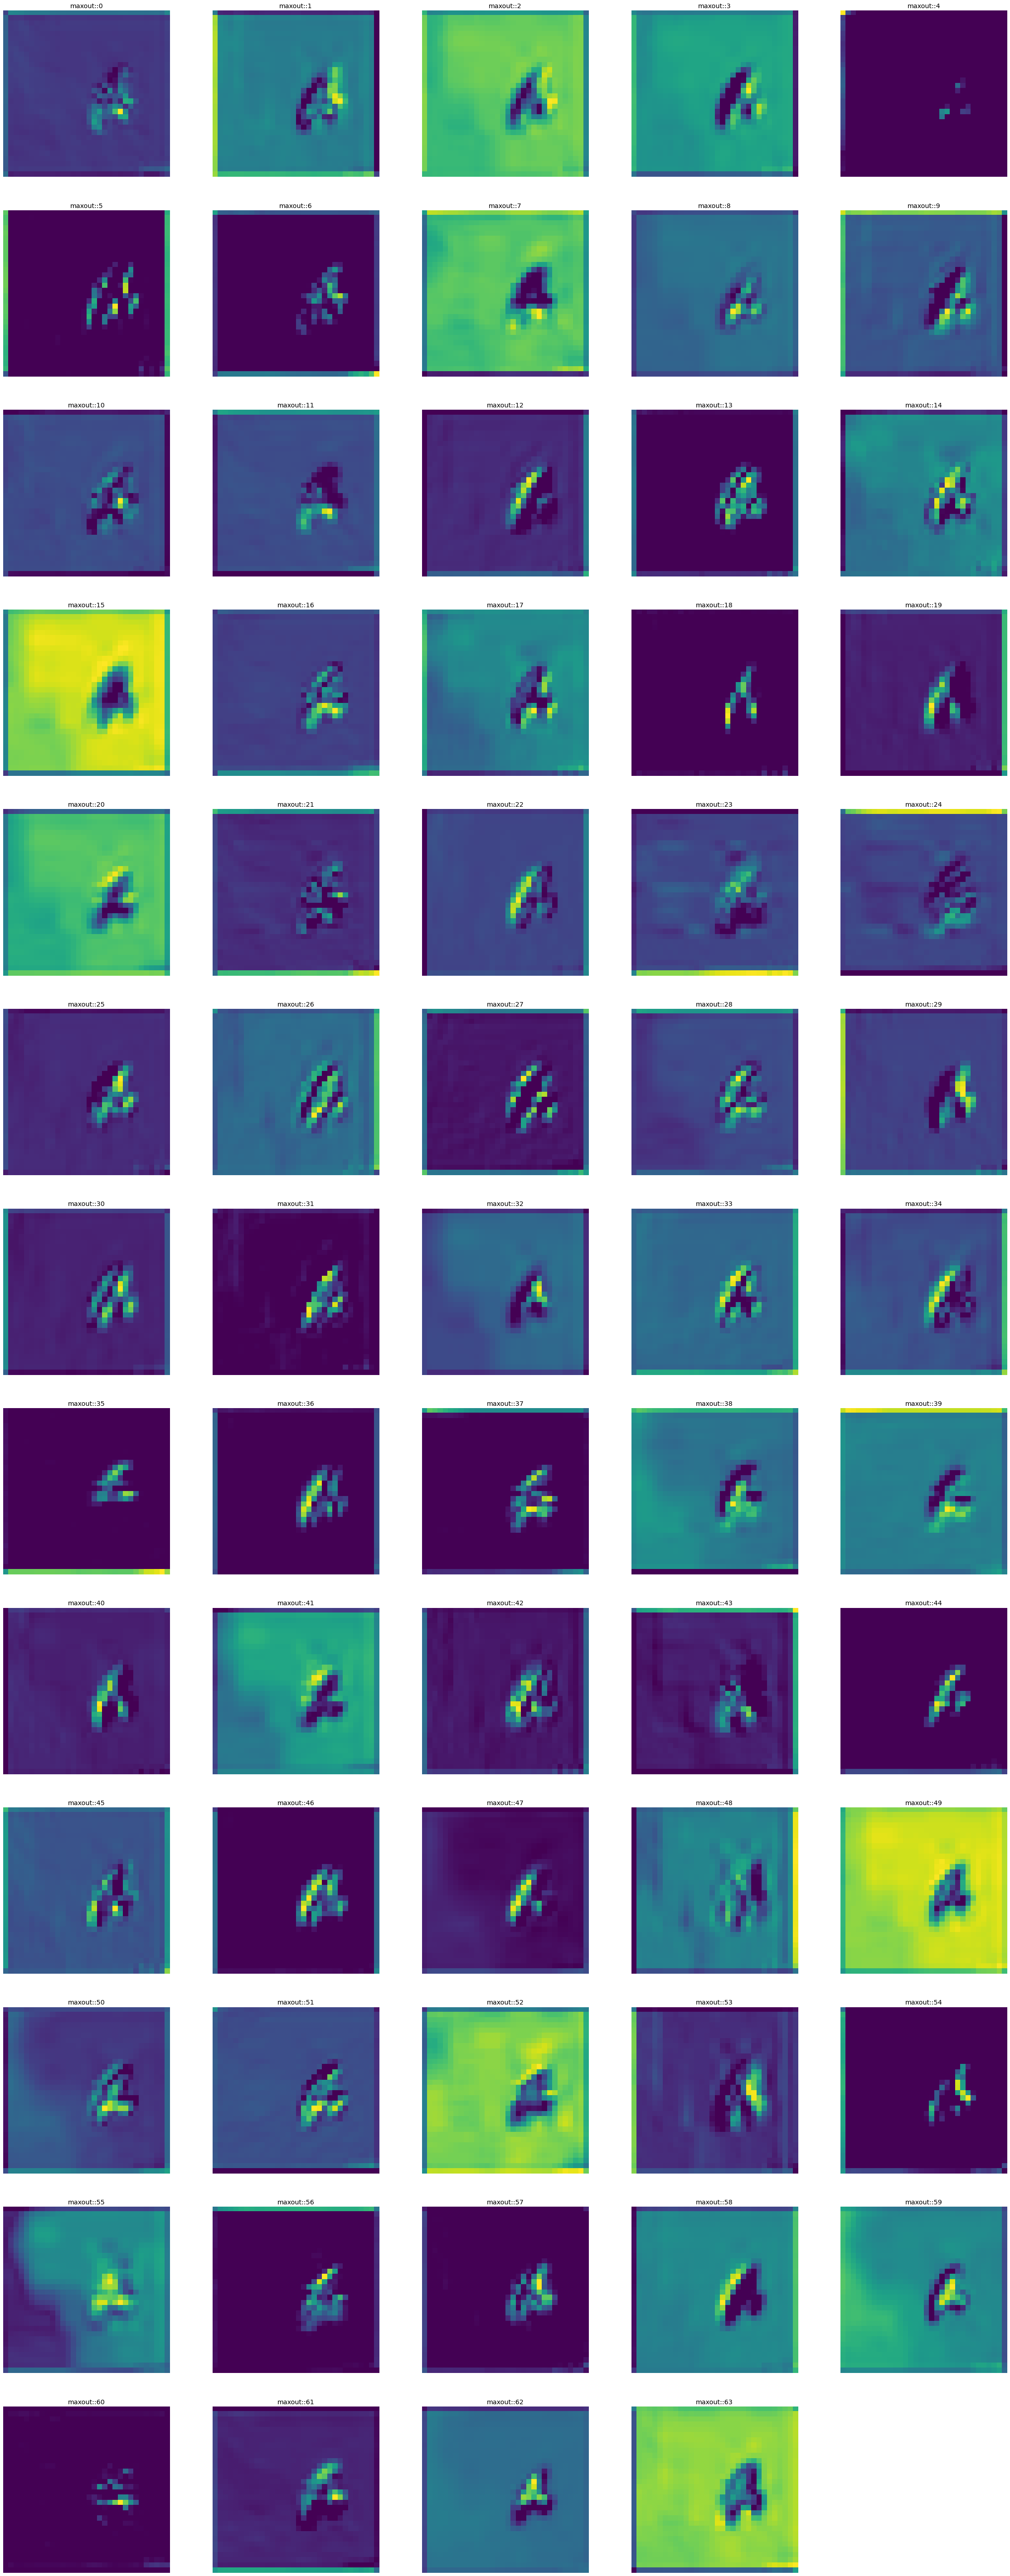

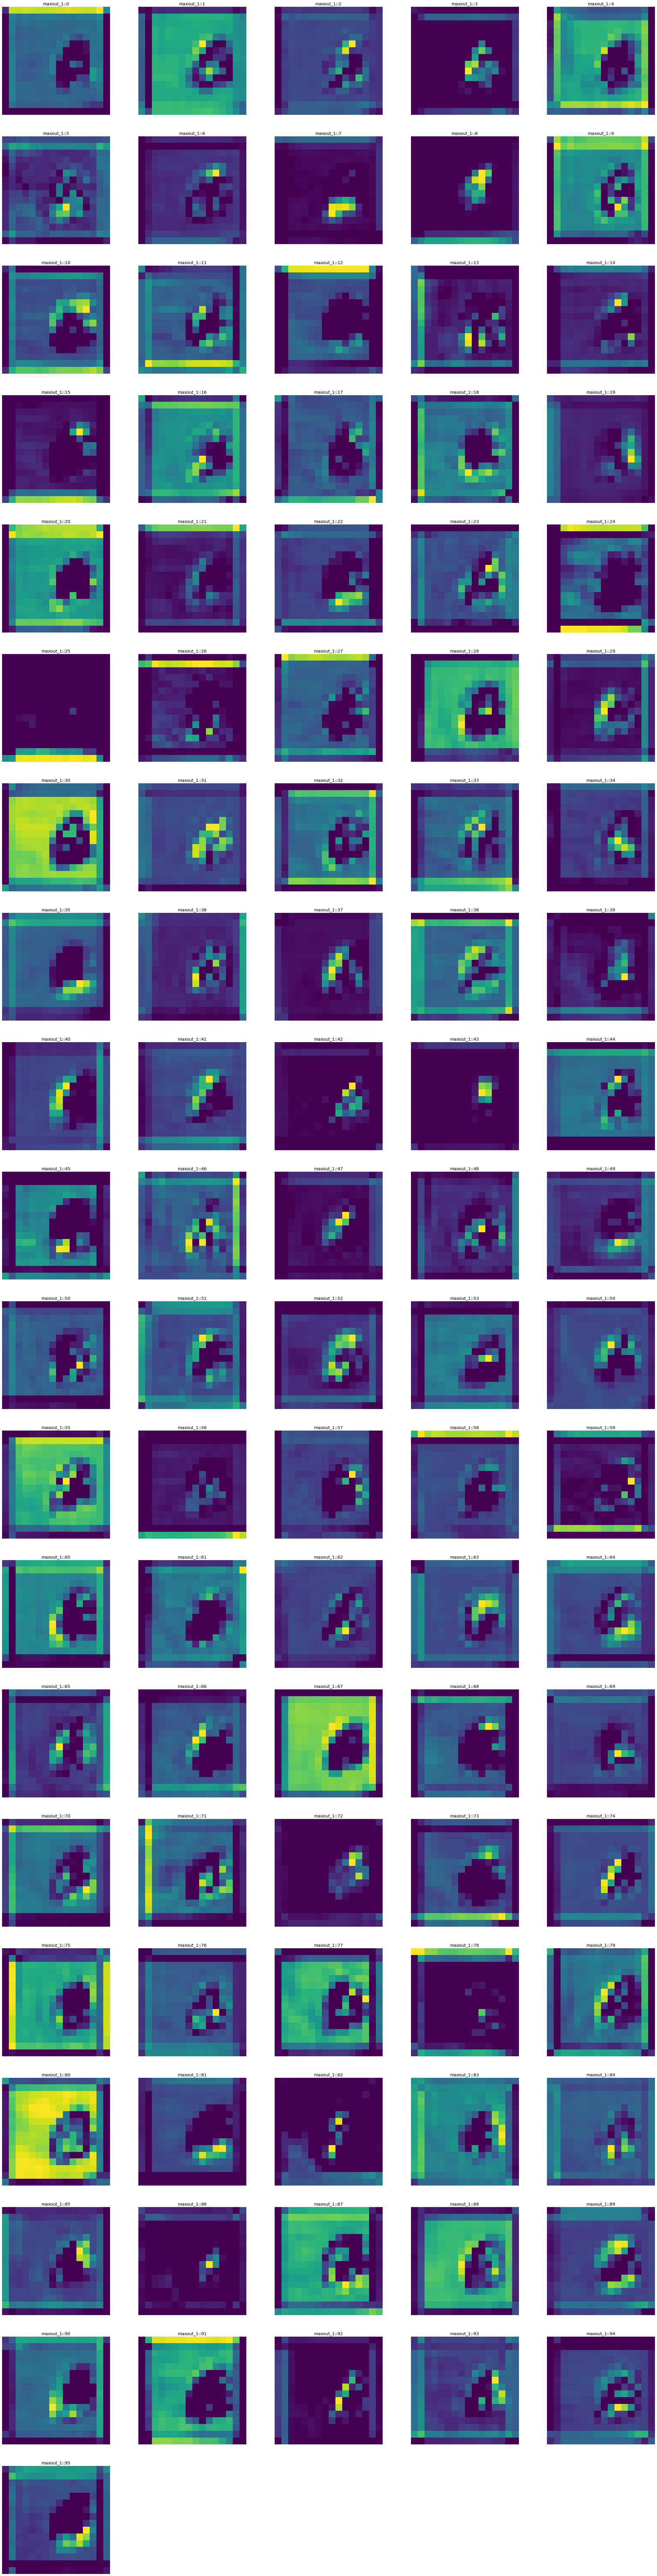

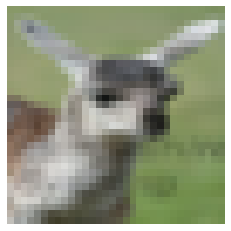

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


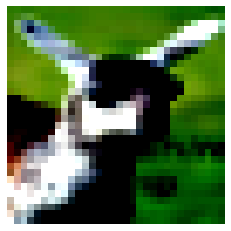

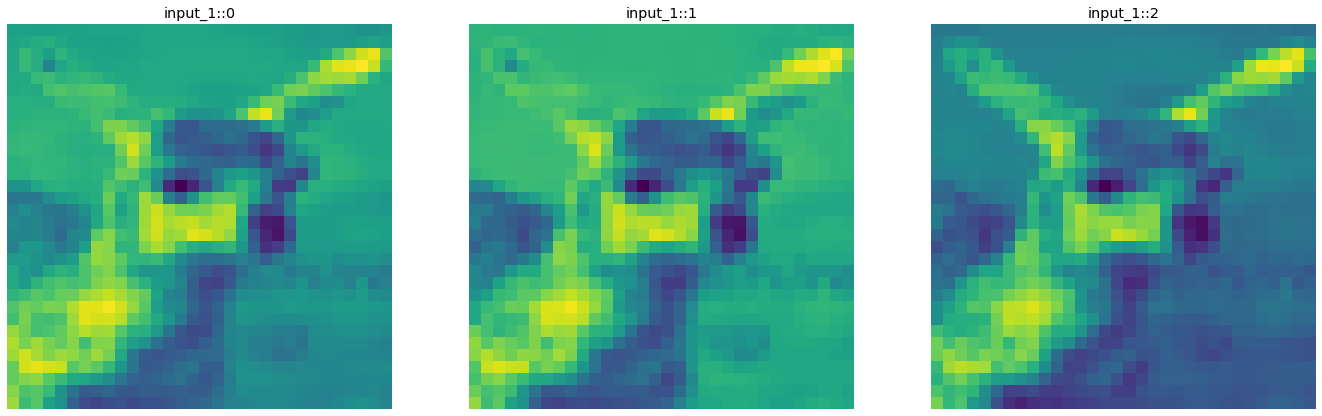

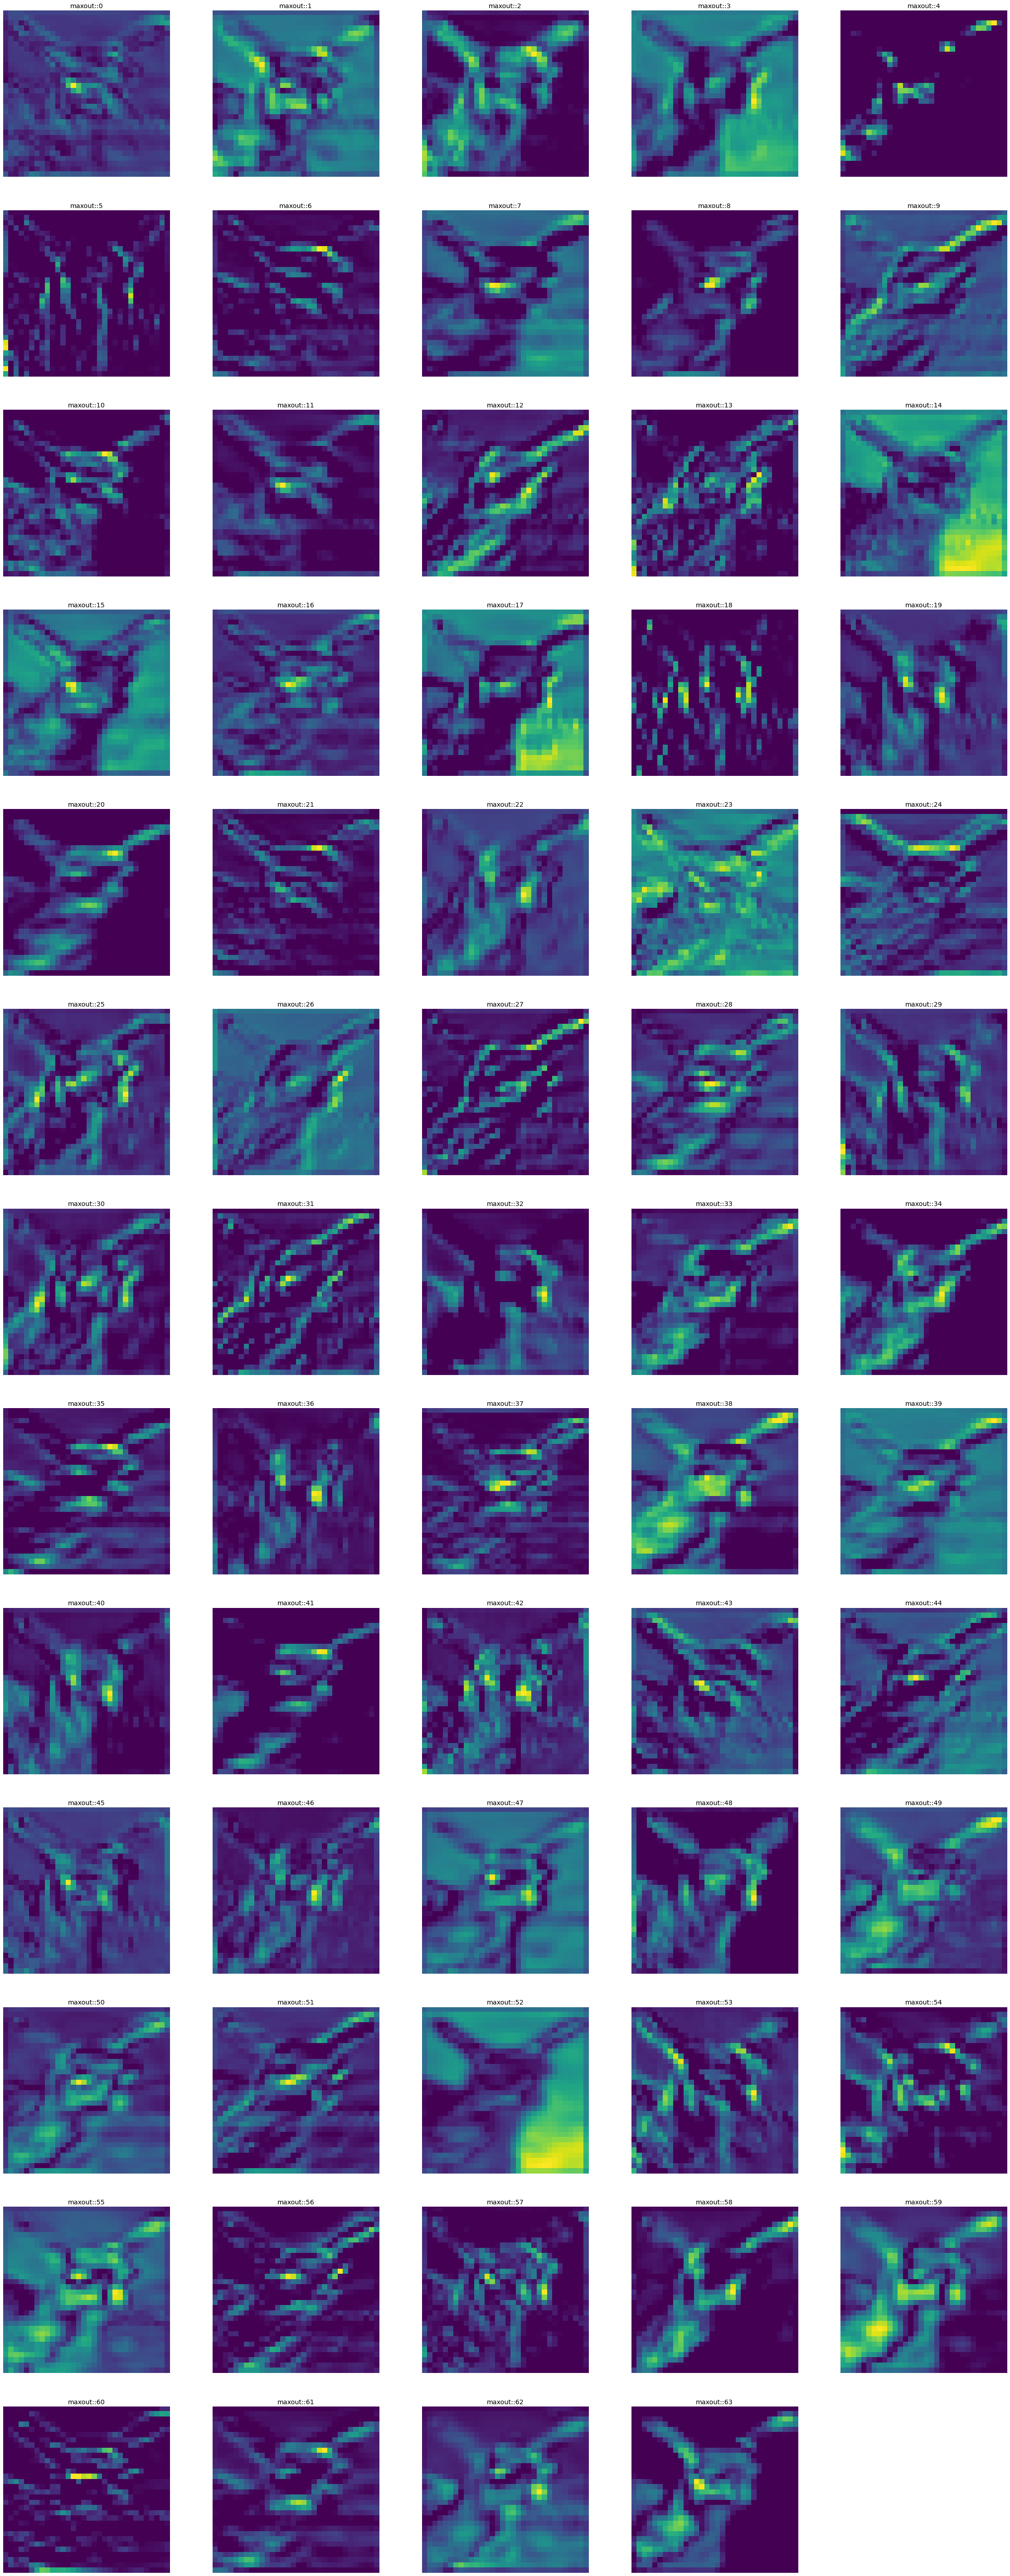

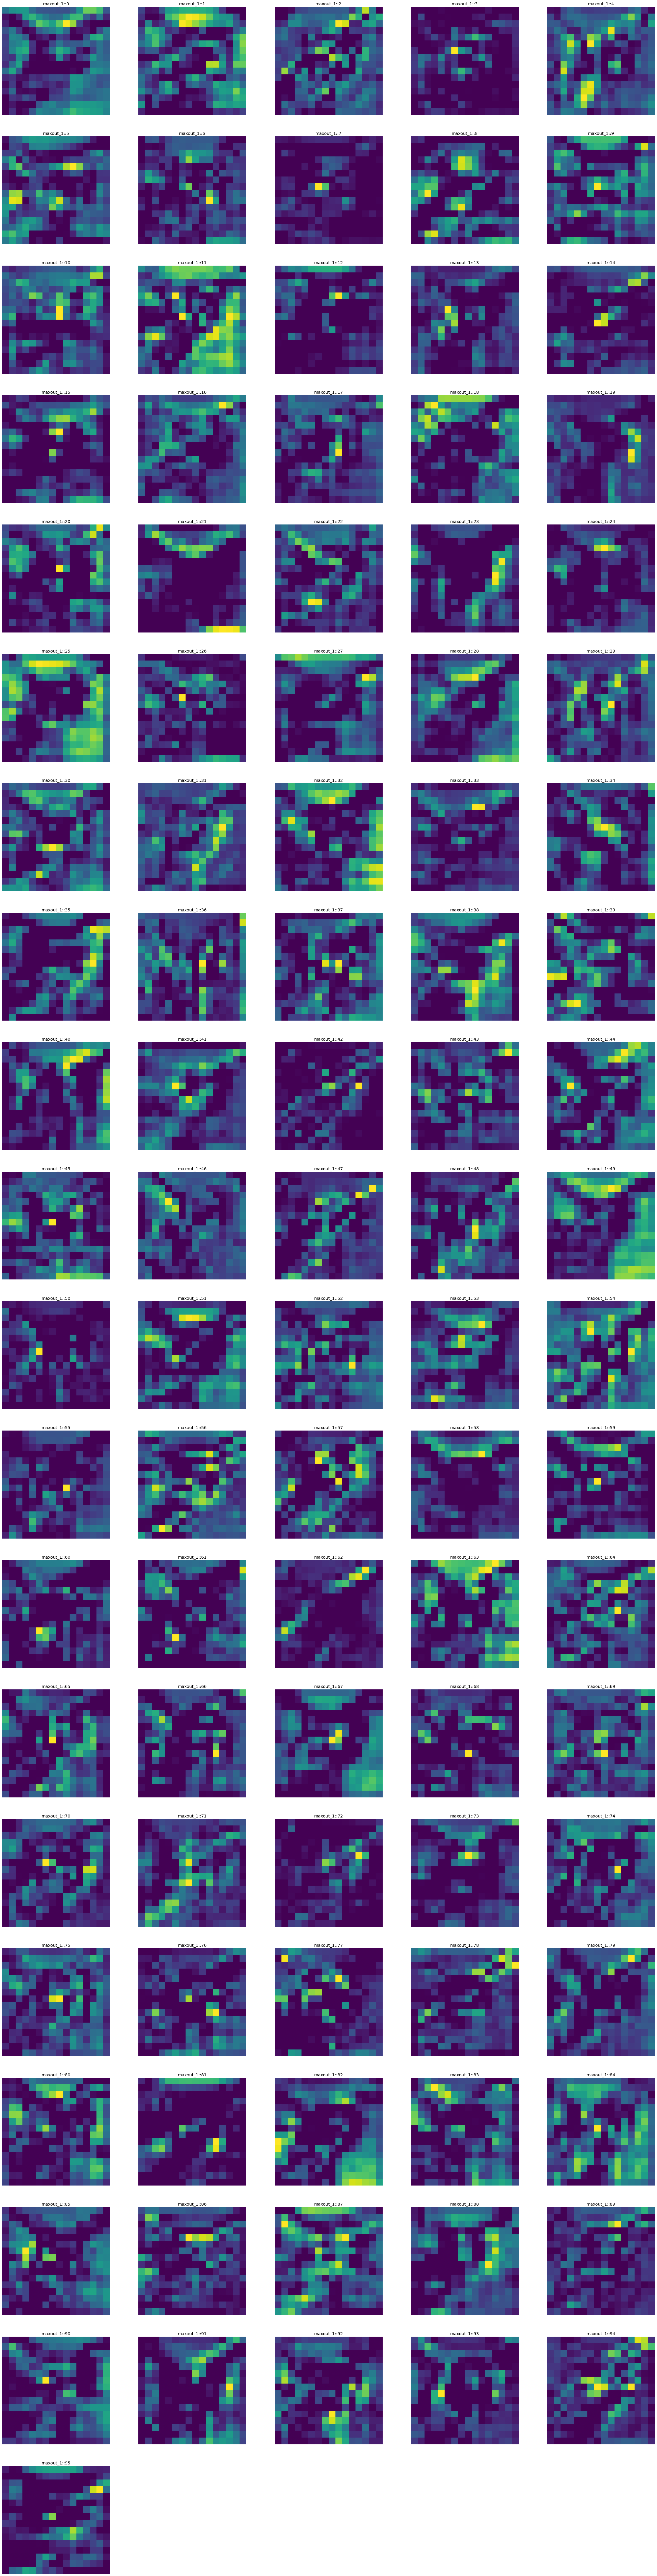

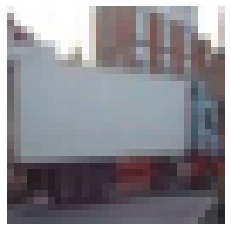

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


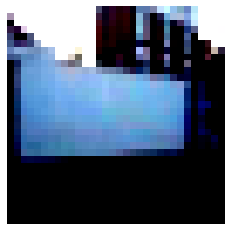

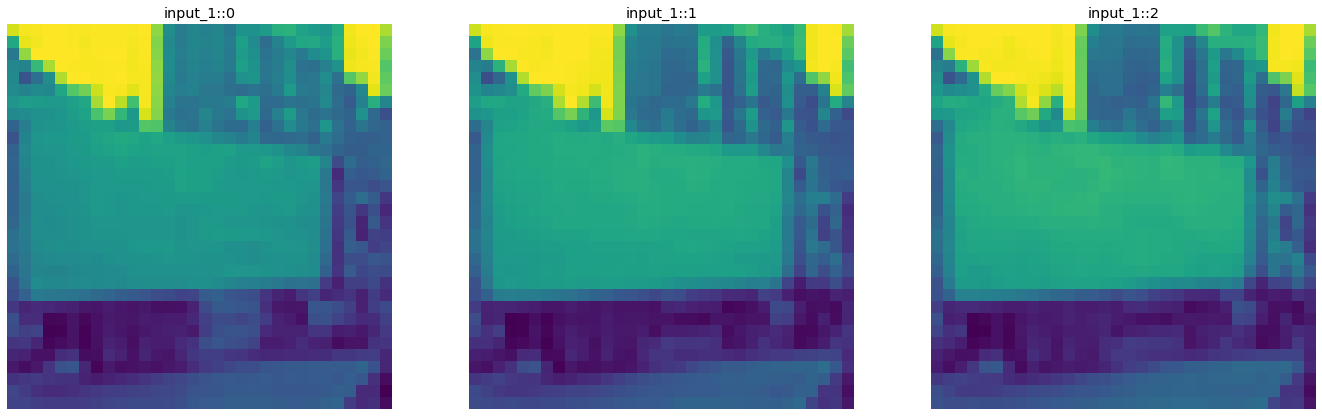

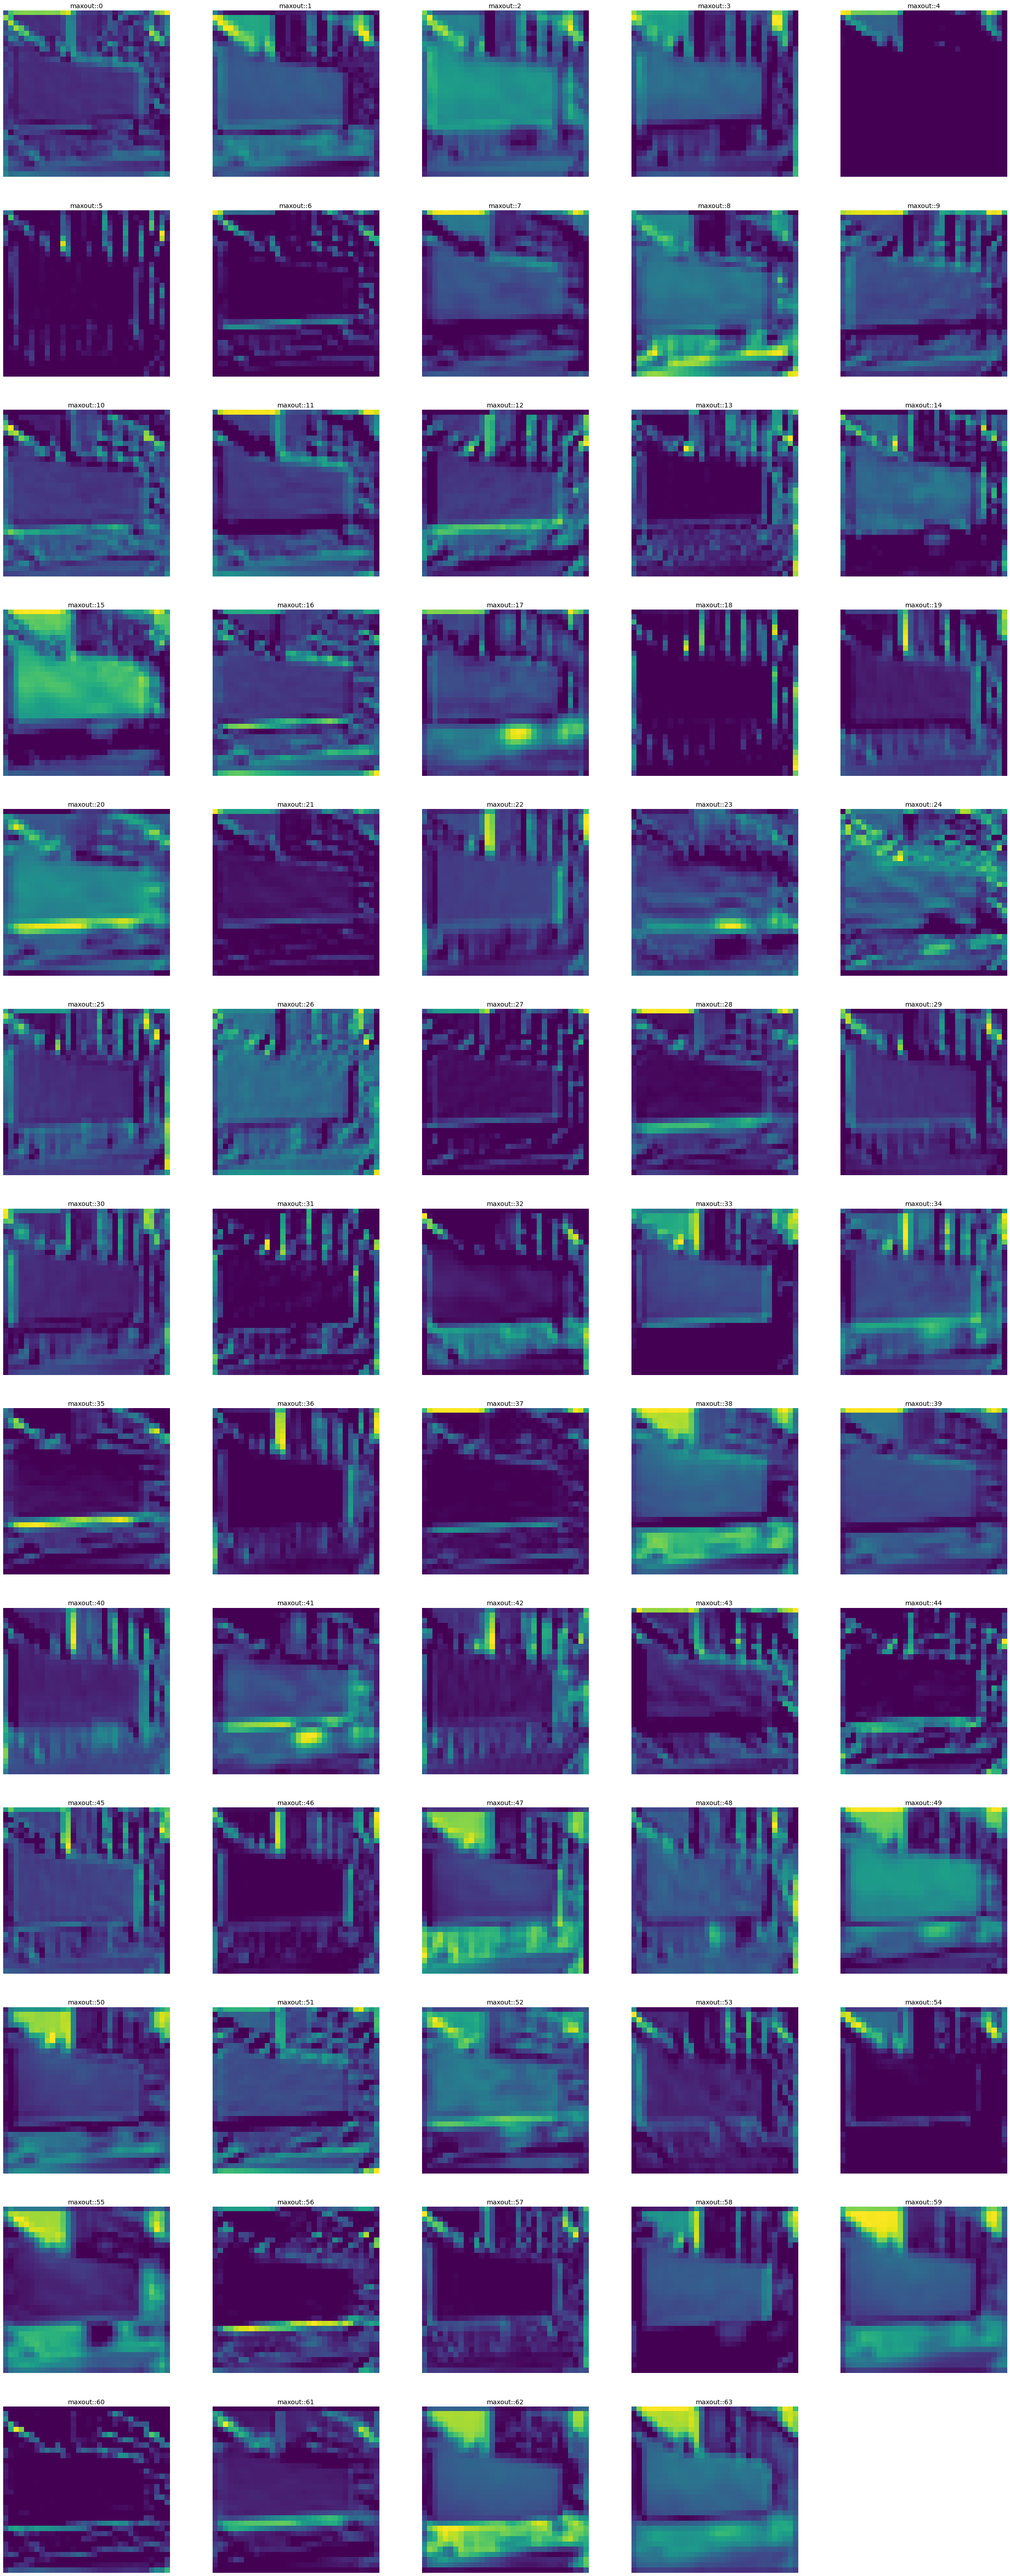

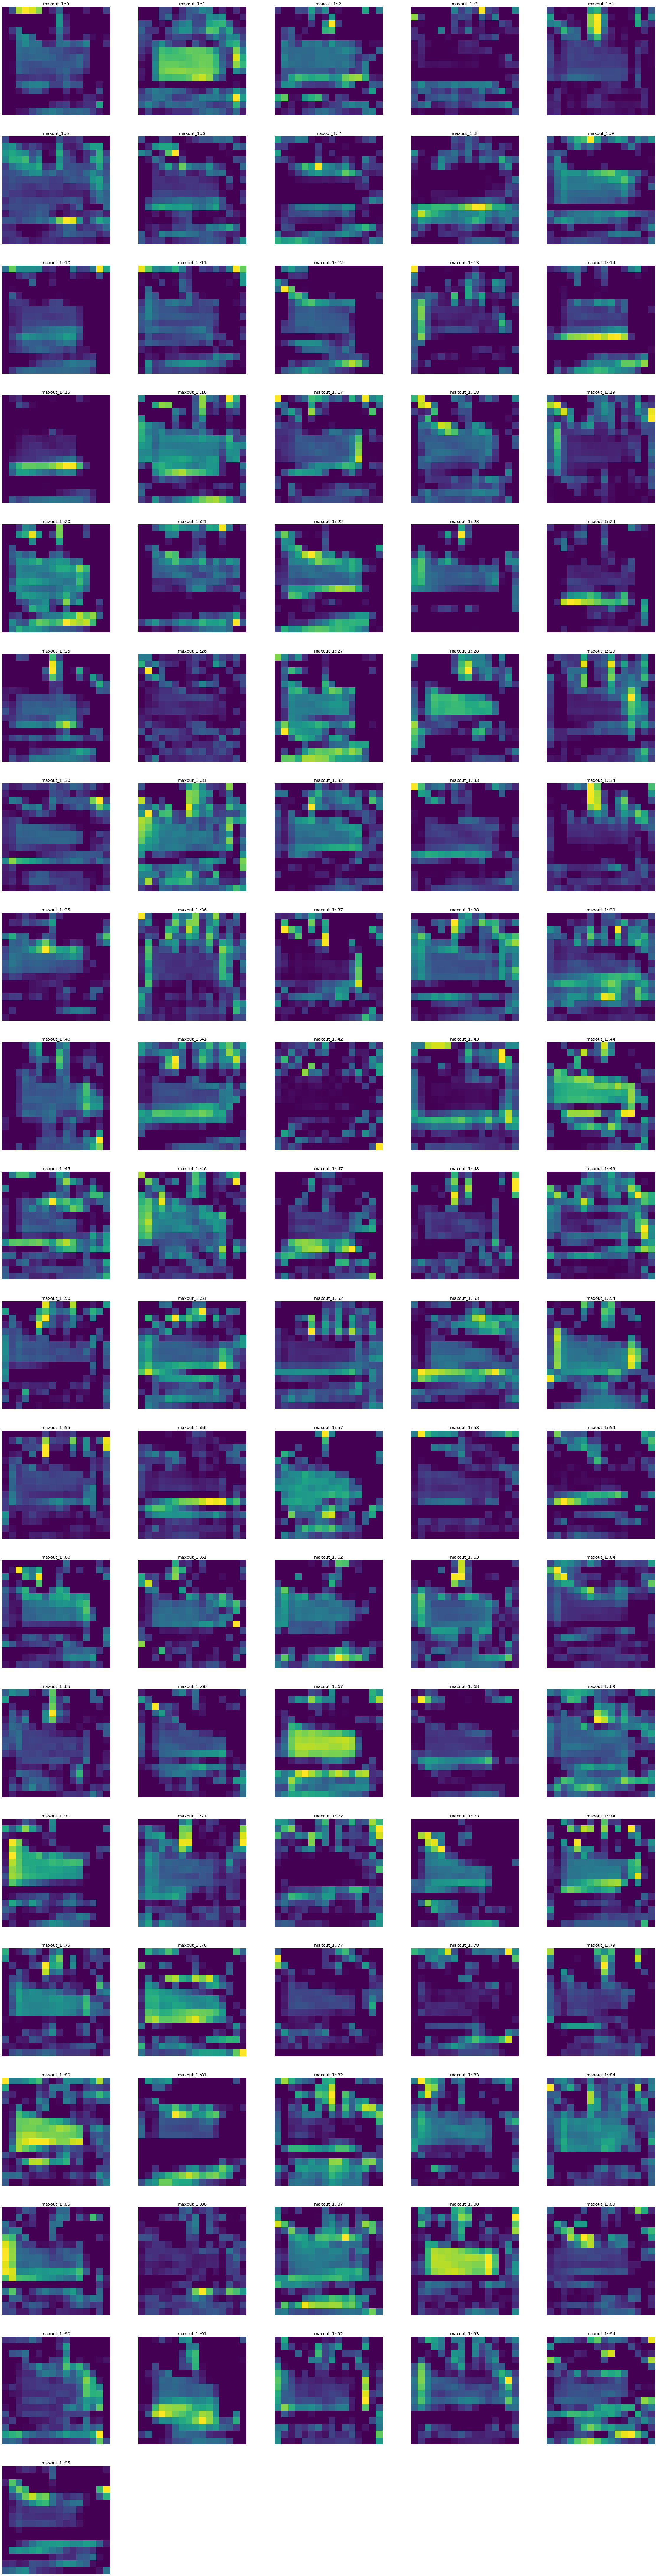

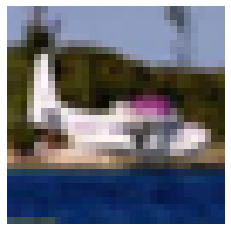

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


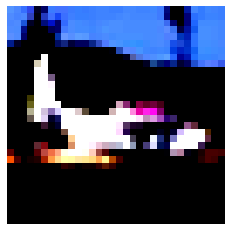

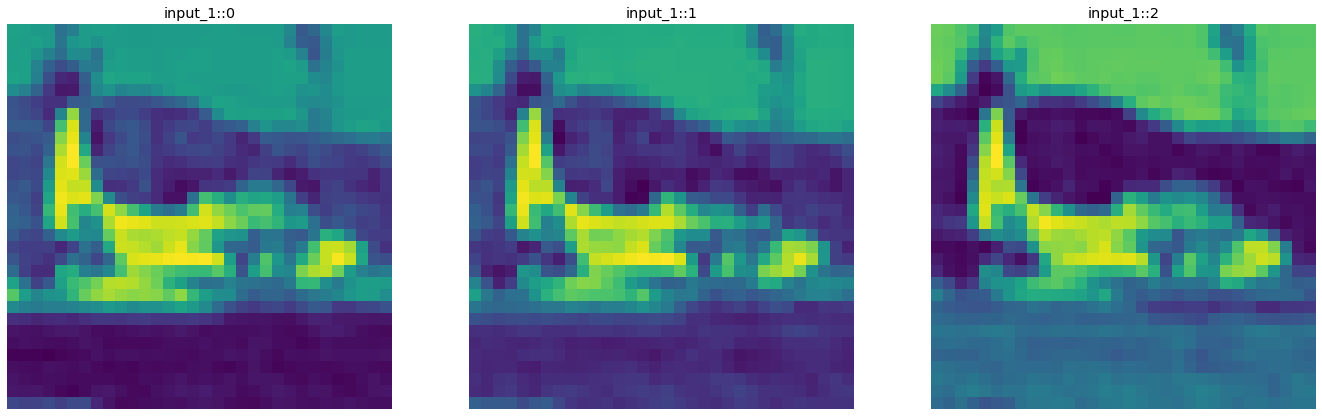

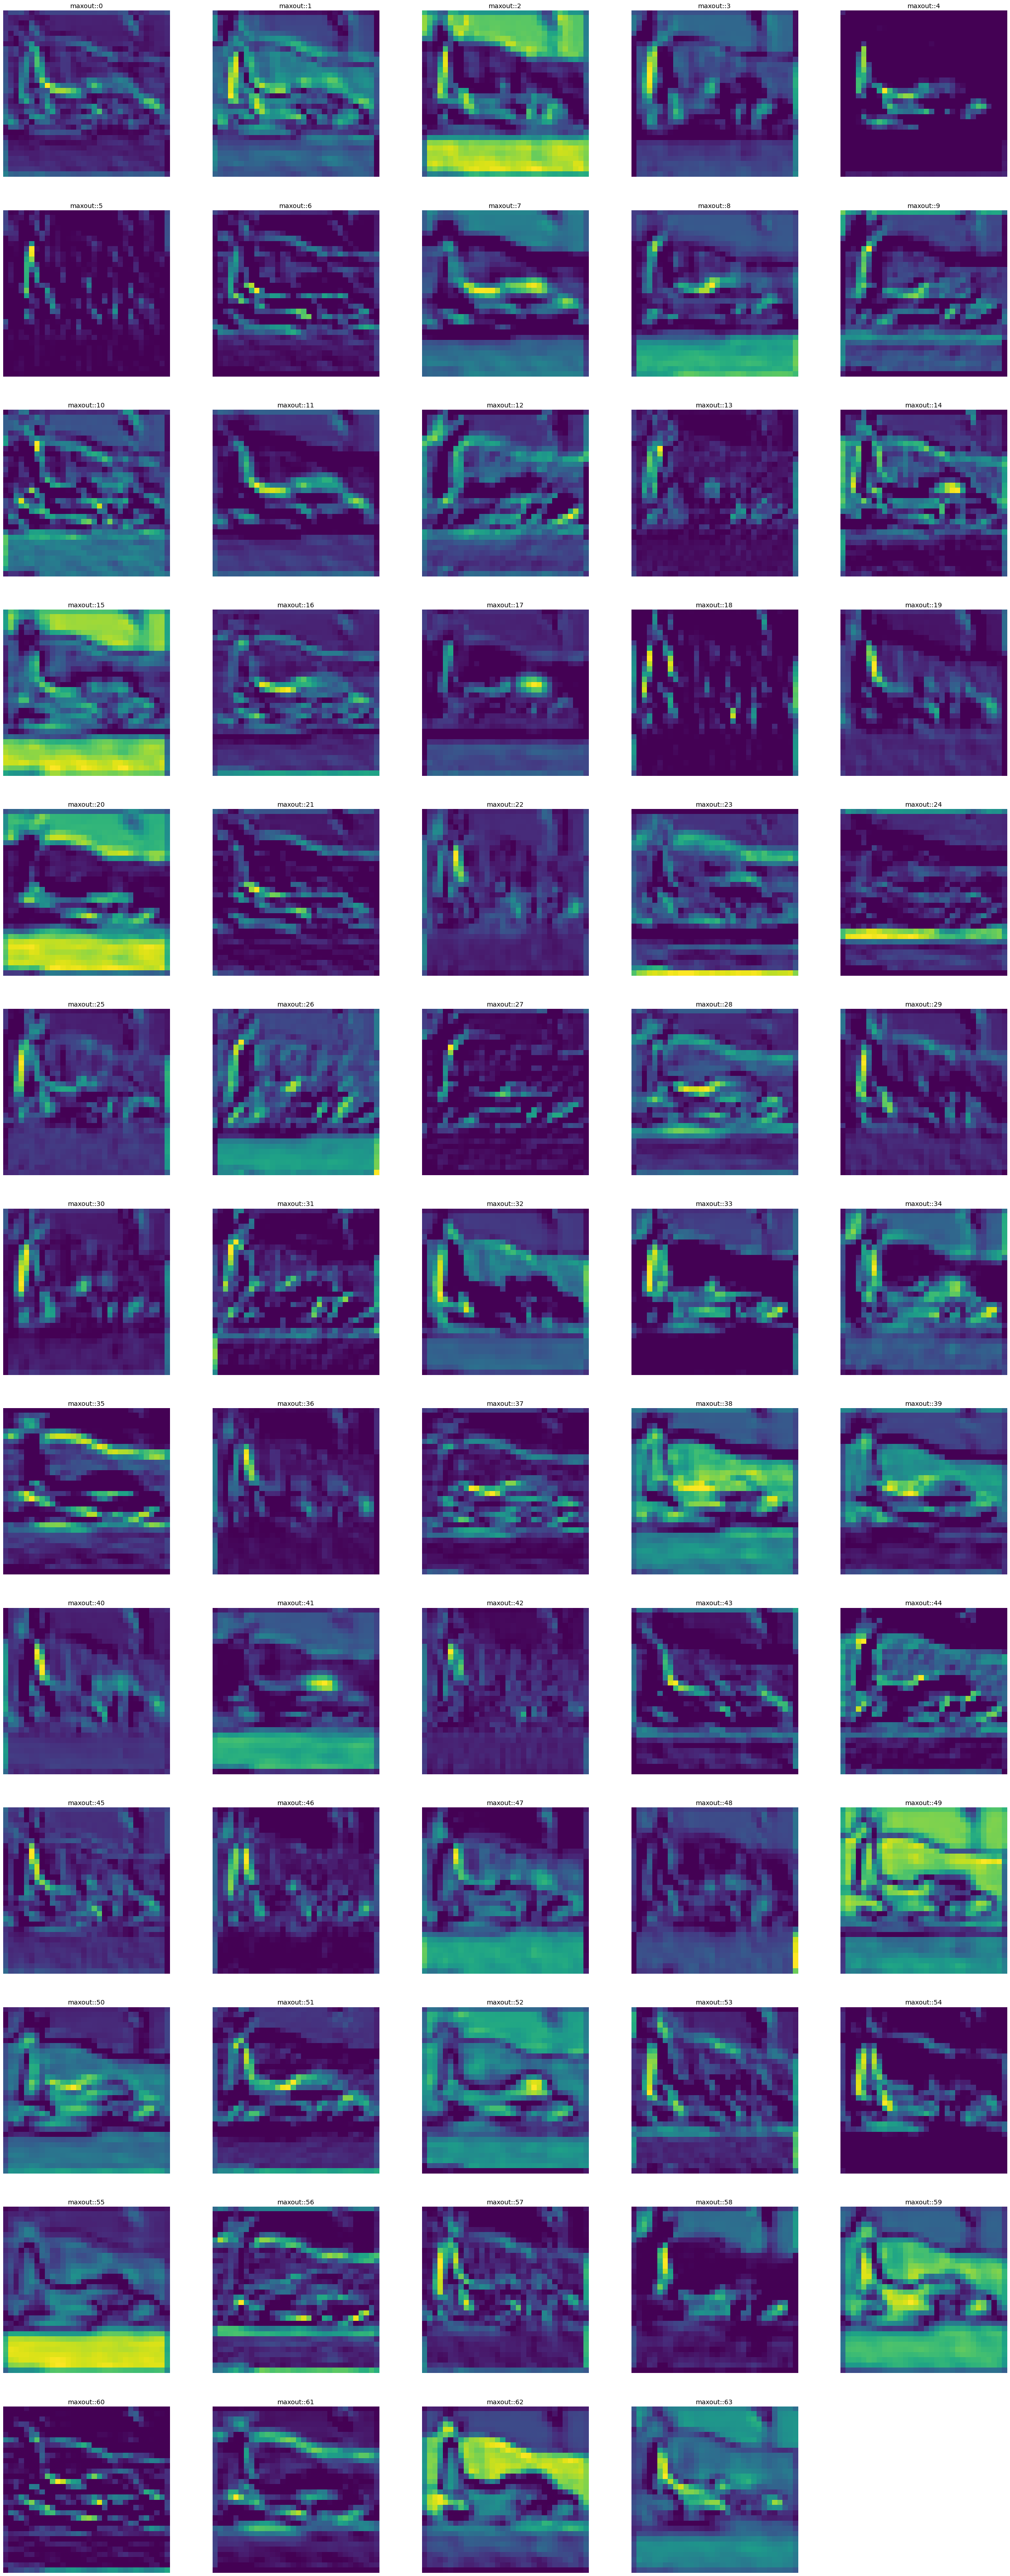

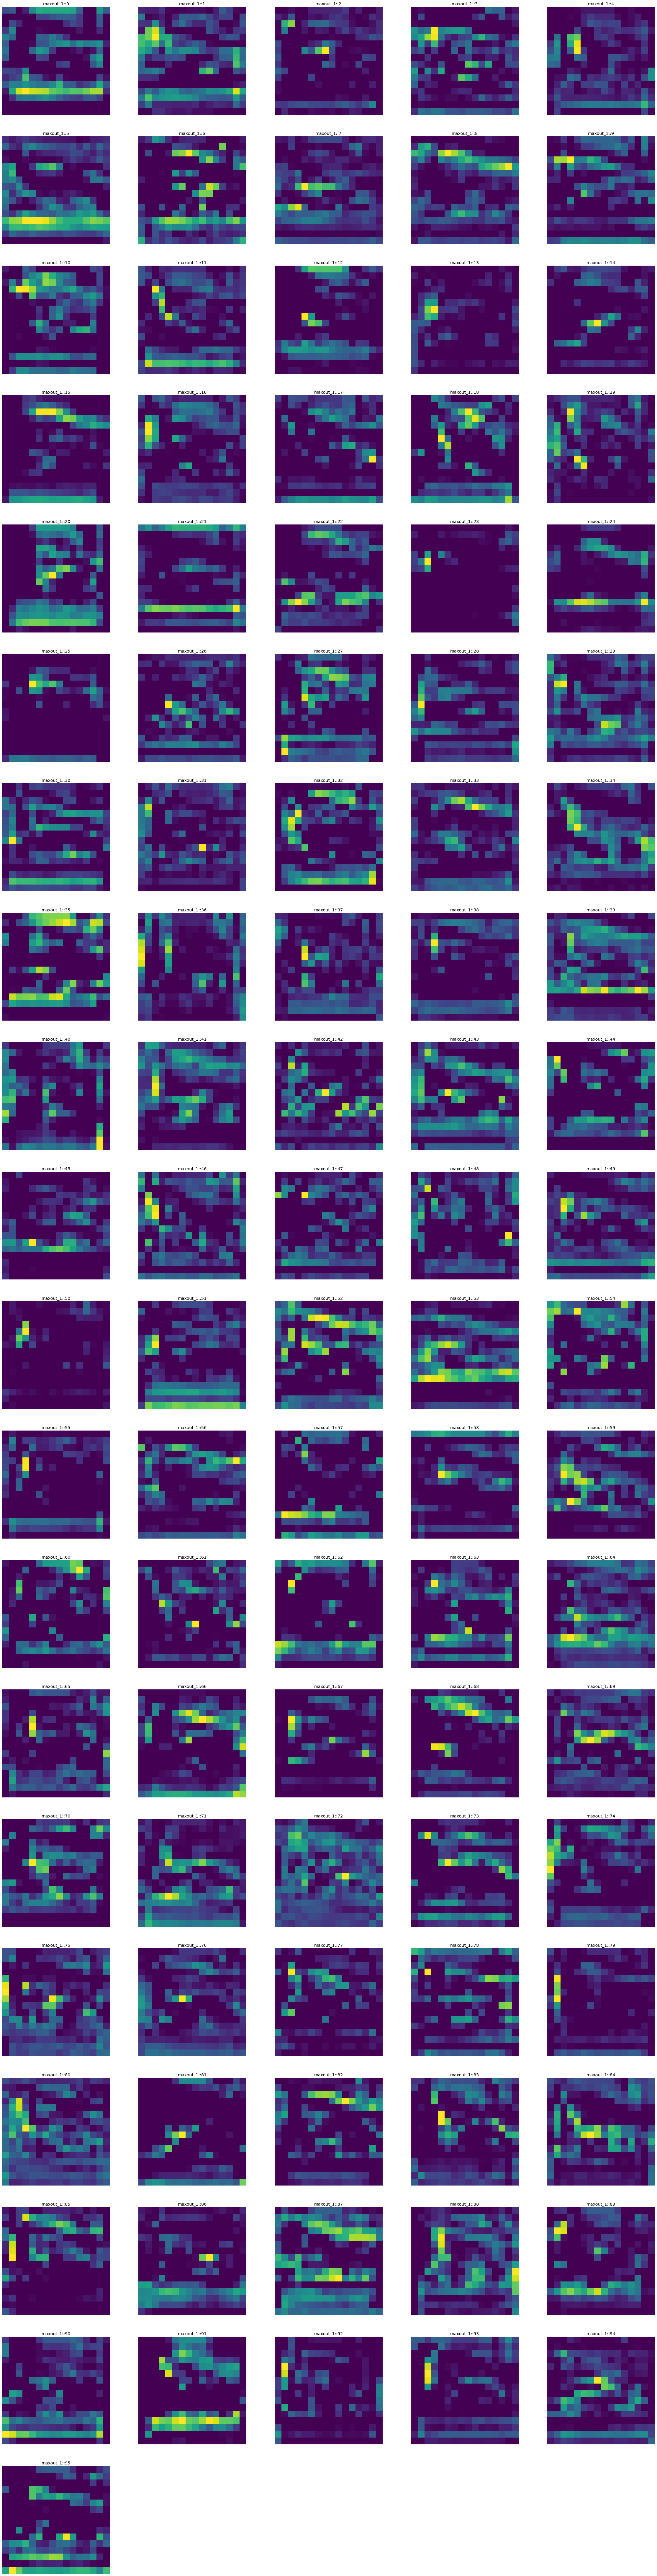

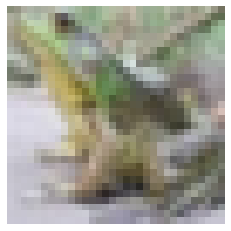

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


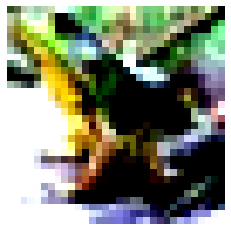

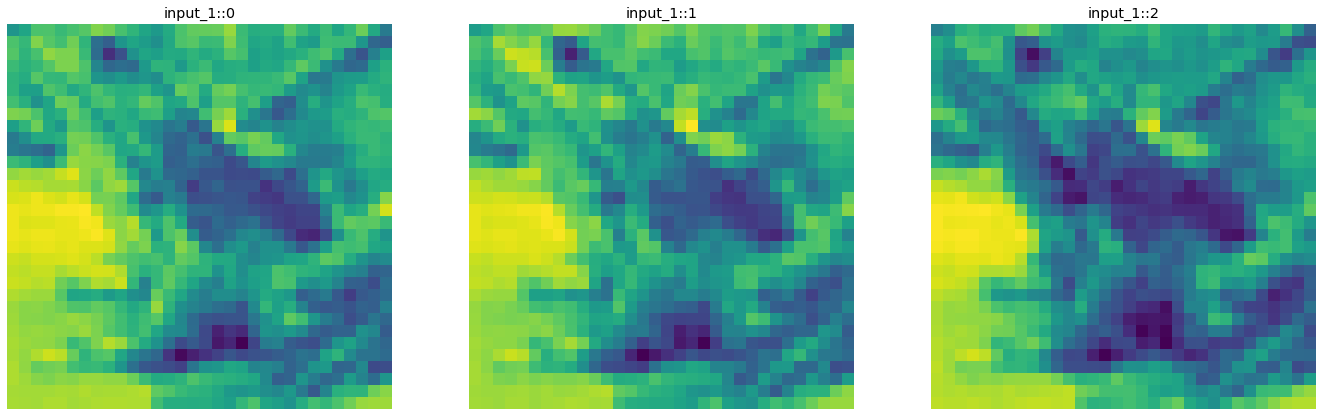

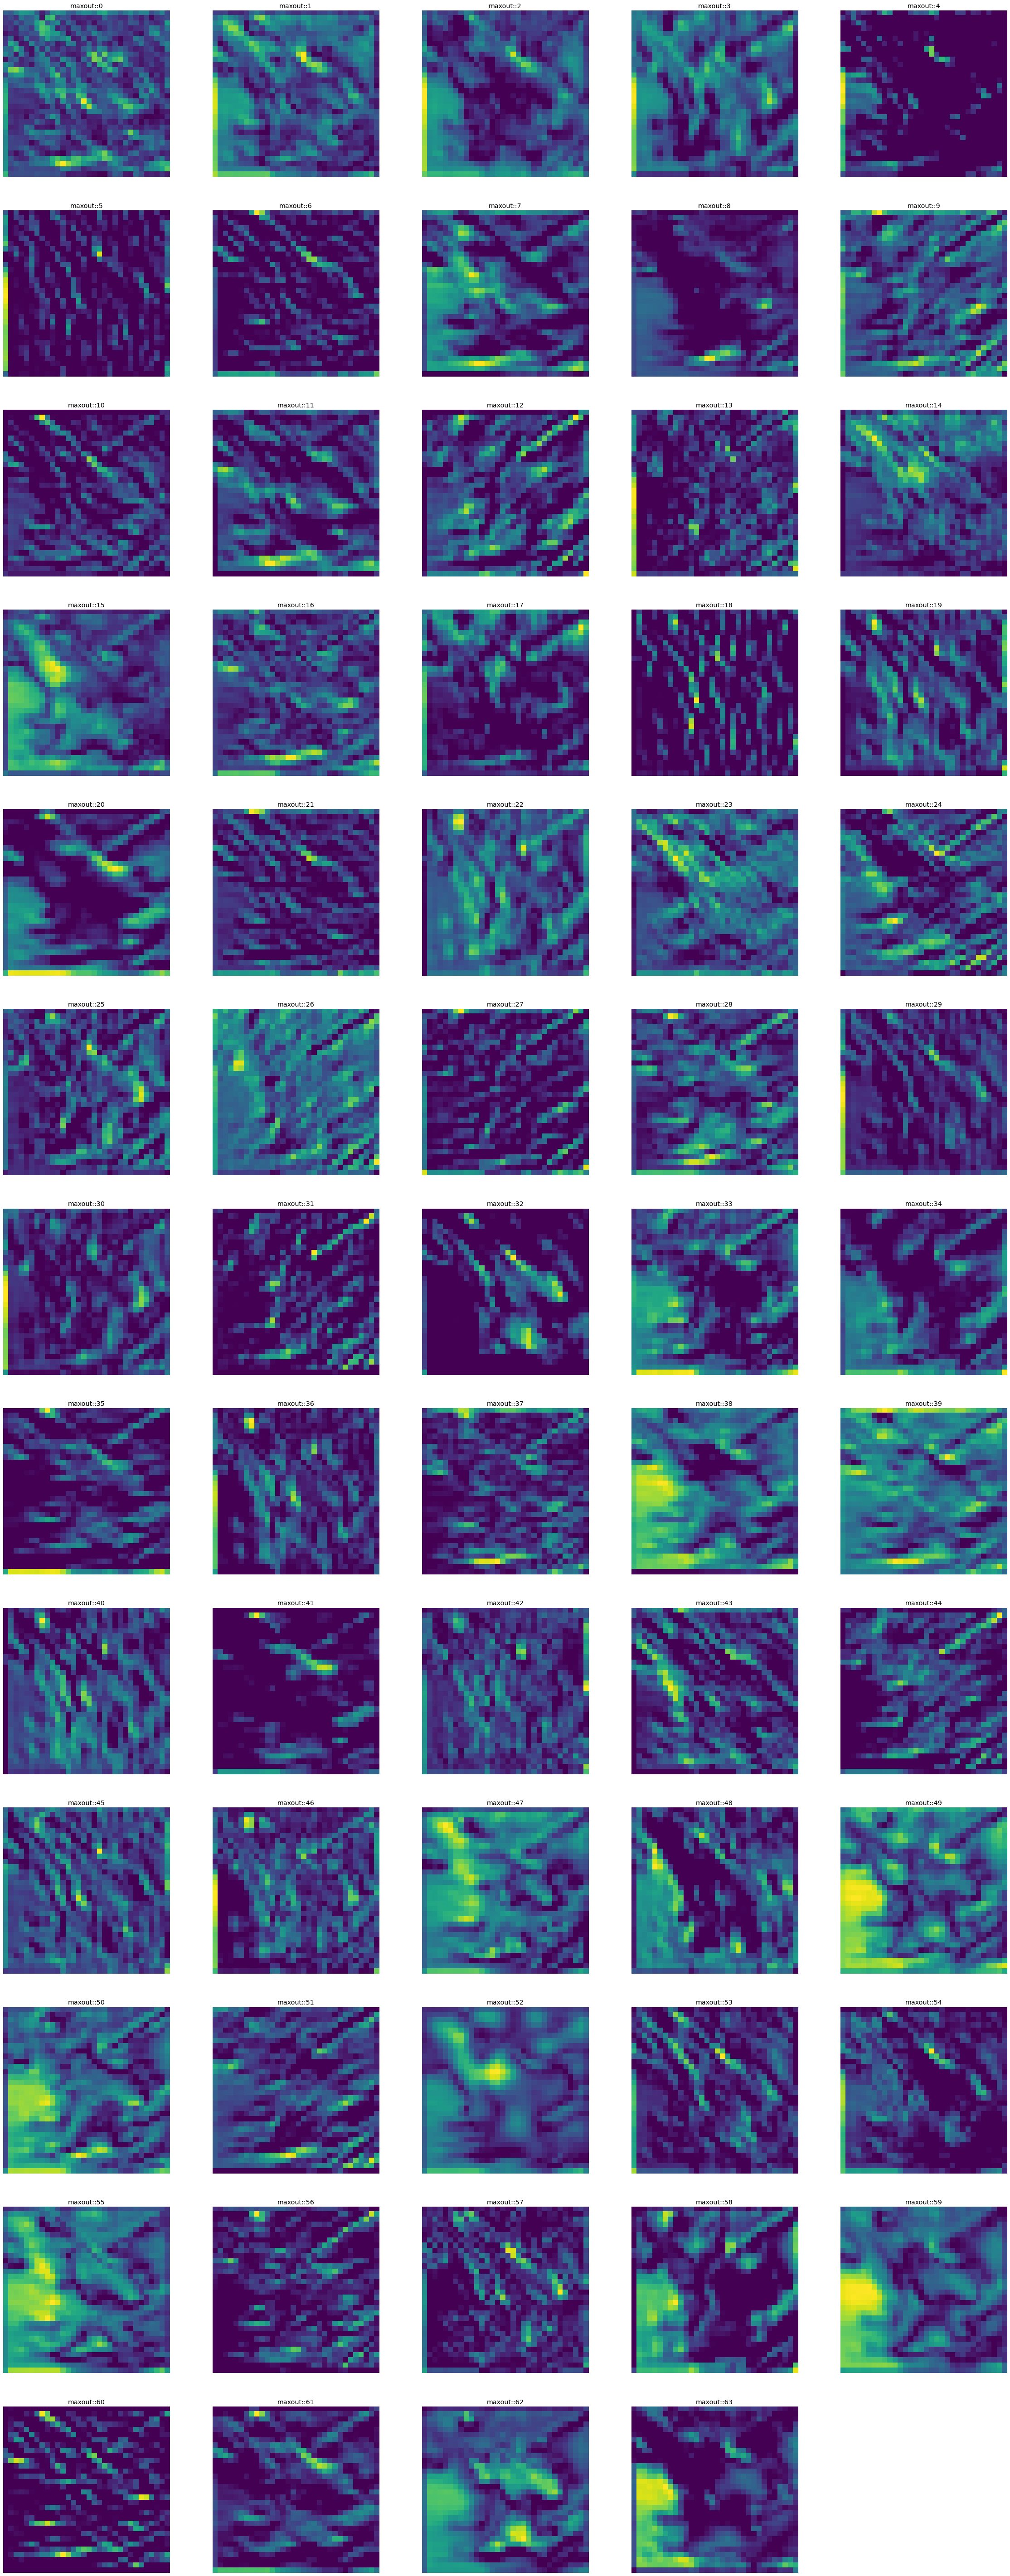

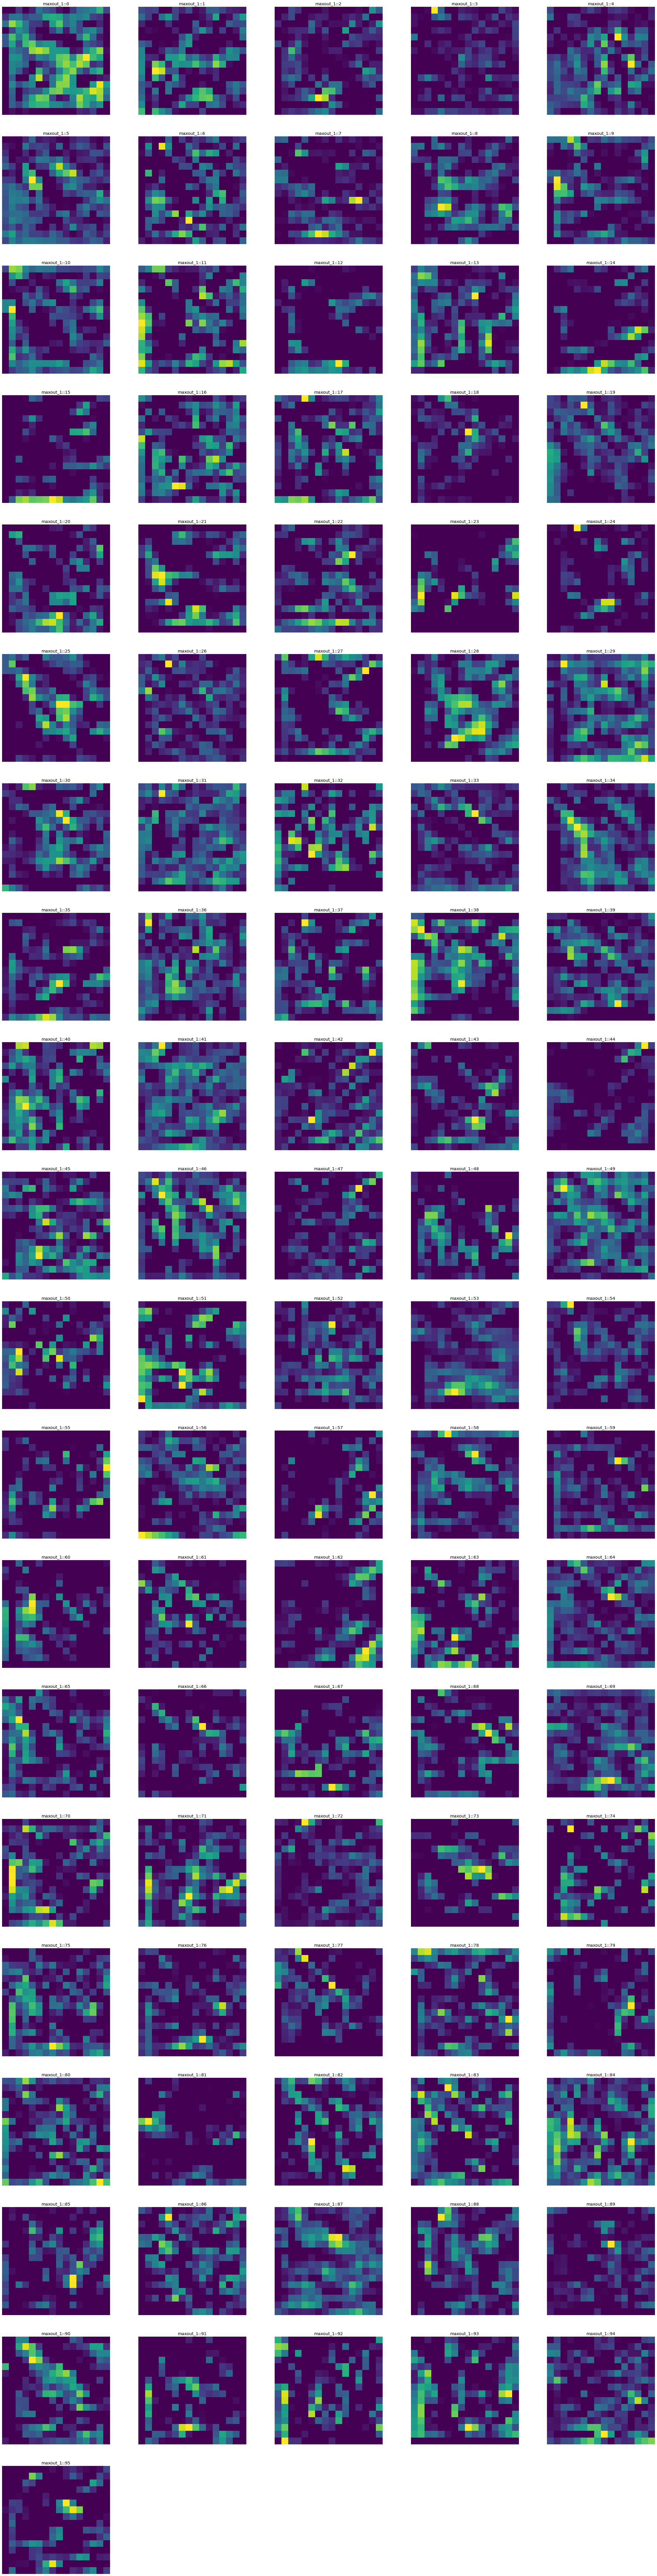

In [8]:
%matplotlib inline

def print_convolutions(image, title='', take=3):
    plt.imshow(image)
    processed_image = test_datagen.flow(image.reshape((1, 32, 32, 3))).next()[0, :, :, :]
    plt.axis('off')
    plt.show()
    plot_convolutions(model, processed_image, printable_layers=['input', 'maxout'], title=title, take=take)
    
test_results_df = get_test_results(model, test_data=test_datagen.flow(x_test, y_test, batch_size=len(x_test))[0])

correct_answers_df = test_results_df[test_results_df['correct'] == True]
correct_answers_df = correct_answers_df.sort_values(by=['confidence'], ascending=False)

correct_answers_top = correct_answers_df.loc[
    correct_answers_df.groupby(['answer'])['confidence'].idxmax()
].sort_values(by=['correct_answer'])['index'].to_list()

for index in correct_answers_top:
    image = x_test[index]
    print_convolutions(image)
    plt.show()